In [1]:
import numpy as np
import pandas as pd
import ringity as rng
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import ringity.generators.geometric_networks as rgeom

from tqdm import tqdm
from pathlib import Path
from itertools import product, combinations
from collections import defaultdict
from scipy.spatial import distance, Delaunay
from sklearn.neighbors import kneighbors_graph
from ringity.readwrite.pdiagrams import json_to_dictofdictoflist, data_to_json

In [2]:
METRICS = ['spl', 'resistance', 'betweenness', 'current_flow']
PALETTE = sns.color_palette(n_colors = len(METRICS))
COLOR_X = sns.color_palette('dark', n_colors = 8)[-1]

In [3]:
def knn_cylinder(n, height,
                 seed = None,
                 **network_params):
    X = rgeom.point_clouds.cylinder(N = n, height = height, seed = seed)
    X += np.random.normal(scale = 2**(-10), size = X.shape)
    G = knn_graph(X, k)
    return G, X


def knn_graph(X, k):
    A = kneighbors_graph(X, k, mode = 'connectivity', include_self = False)
    B = A.tocoo()
    edges = [edge for edge in zip(B.row, B.col)]
    G = nx.Graph()
    G.add_edges_from(edges)
    return G

def update_data_dict(data_dict, 
                     network_generator,
                     network_params, 
                     sweep_val,
                     sweep_param,
                     point_cloud = False):
    while True:
        if point_cloud:
            G, X = network_generator(**network_params, 
                                     **{sweep_param : sweep_val})  
        else:
            G = network_generator(**network_params, 
                                  **{sweep_param : sweep_val})
        if nx.is_connected(G):
            break
    
    if point_cloud:
        pdgm_X = rng.pdiagram_from_point_cloud(X)
        data_dict['X'][sweep_val].append(pdgm_X.trimmed(25))

    for metric in METRICS:
        pdgm = rng.pdiagram_from_network(G, metric = metric)
        data_dict[metric][sweep_val].append(pdgm.trimmed(25))
        
        
def data_dict_to_scores_df(data_dict, 
                           key1_name = 'metric',
                           key2_name = 'sweep_param'):
    to_concatinate = []
    for key1, data in data_dict.items():
        for key2, pdgms in data.items():
            scores = list(map(rng.ring_score, pdgms))
            df_metric_chunk = pd.DataFrame({'scores' : scores,
                                            key1_name : key1,
                                            key2_name : key2})
            to_concatinate.append(df_metric_chunk)

    scores_df = pd.concat(to_concatinate, ignore_index = True)
    return scores_df

---

# Network models

## Watts-Strogatz

### Set Parameters

In [5]:
# Network parameters
n = 1000
k = 10

sweep_param = 'p'
nb_sweep_vals = 2**5 + 1
min_sweep_val = 0
max_sweep_val = 1

network_generator = nx.watts_strogatz_graph
network_params = {'n' : n, 'k' : k}
fname_data = Path(f'../../../data/pdgms_WS_N{n}-k{k}.json')

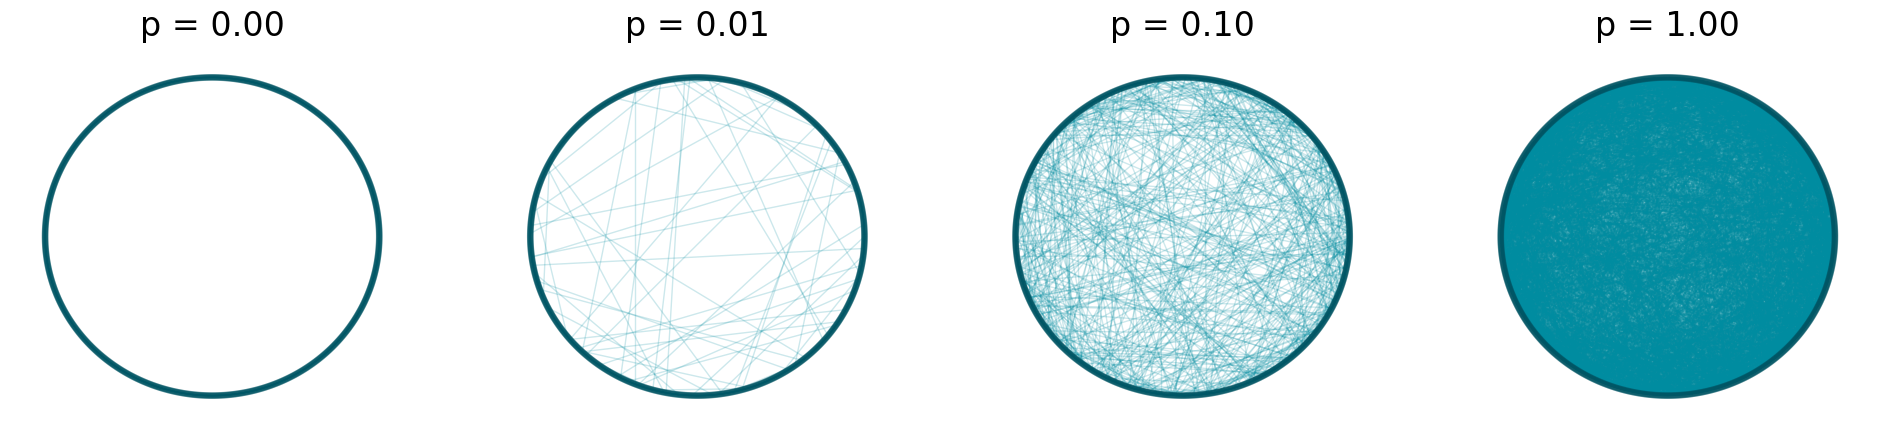

In [6]:
nb_plots = 4

sweep_vals = np.hstack([0.0, np.logspace(-(nb_plots-2), np.log10(max_sweep_val), nb_plots-1)])

fig, axes = plt.subplots(1, nb_plots, figsize = (6*nb_plots, 5))
pos = {i:(np.cos(i*2*np.pi/n), np.sin(i*2*np.pi/n)) for i in range(n)}
for i, sweep_val in enumerate(sweep_vals):
    ax = axes[i]
    G = network_generator(**network_params, **{sweep_param : sweep_val})
    rng.plot_nx(G, ax = ax, pos = pos)
    ax.set_title(f'{sweep_param} = {sweep_val:.2f}', size = 24)

### Calculations

In [6]:
# Calculation parameters
nb_samples = 2**0
new_calculation = False

In [7]:
samples = range(nb_samples)
sweep_vals = np.linspace(start = min_sweep_val, 
                         stop = max_sweep_val, 
                         num = nb_sweep_vals).round(6)

total = nb_samples * nb_sweep_vals
pbar = tqdm(product(sweep_vals, samples), total = total)

data_dict = json_to_dictofdictoflist(fname_data, 
                                     new = new_calculation, 
                                     lambda_key2 = float)
for sweep_val, _ in pbar:
    update_data_dict(data_dict = data_dict,
                     network_generator = network_generator, 
                     network_params = network_params, 
                     sweep_val = sweep_val,
                     sweep_param = sweep_param,
                     point_cloud = False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [28:10<00:00, 51.23s/it]


In [8]:
data_to_json(fname_data, data_dict)

### Ploting

In [7]:
data_dict = json_to_dictofdictoflist(fname_data, lambda_key2=float)

In [8]:
scores_df = (data_dict_to_scores_df(data_dict, key2_name = sweep_param).
                rename({'sweep' : sweep_param}, axis = 1))

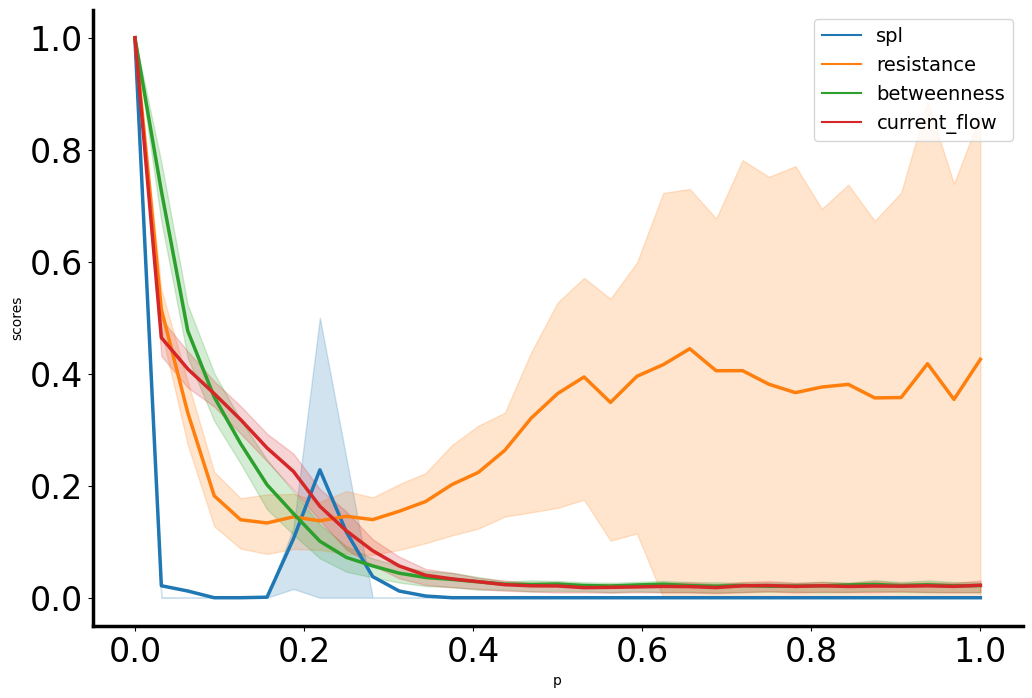

In [9]:
SFig_sum, ax_sum = plt.subplots(figsize = (12,8))

# plot_data = scores_df[scores_df.metric.isin({'X', 'spl', 'resistance'})]
plot_data = scores_df

ax_sum = sns.lineplot(data = plot_data, 
                      x = sweep_param, 
                      y = 'scores', 
                      hue = 'metric', 
                      linewidth = 2.5,
                      errorbar = ('pi', 50),
                      palette = PALETTE[:plot_data.metric.nunique()],
                      ax = ax_sum)

rng.plotting.styling.ax_setup(ax_sum)

leg = ax_sum.legend(fontsize = 14)

SFig_sum.savefig(f'data/SFig-metric_analysis-WS_N{n}_k{k}-summary.png')
SFig_sum.savefig(f'data/SFig-metric_analysis-WS_N{n}_k{k}-summary.pdf')

### Panel plot

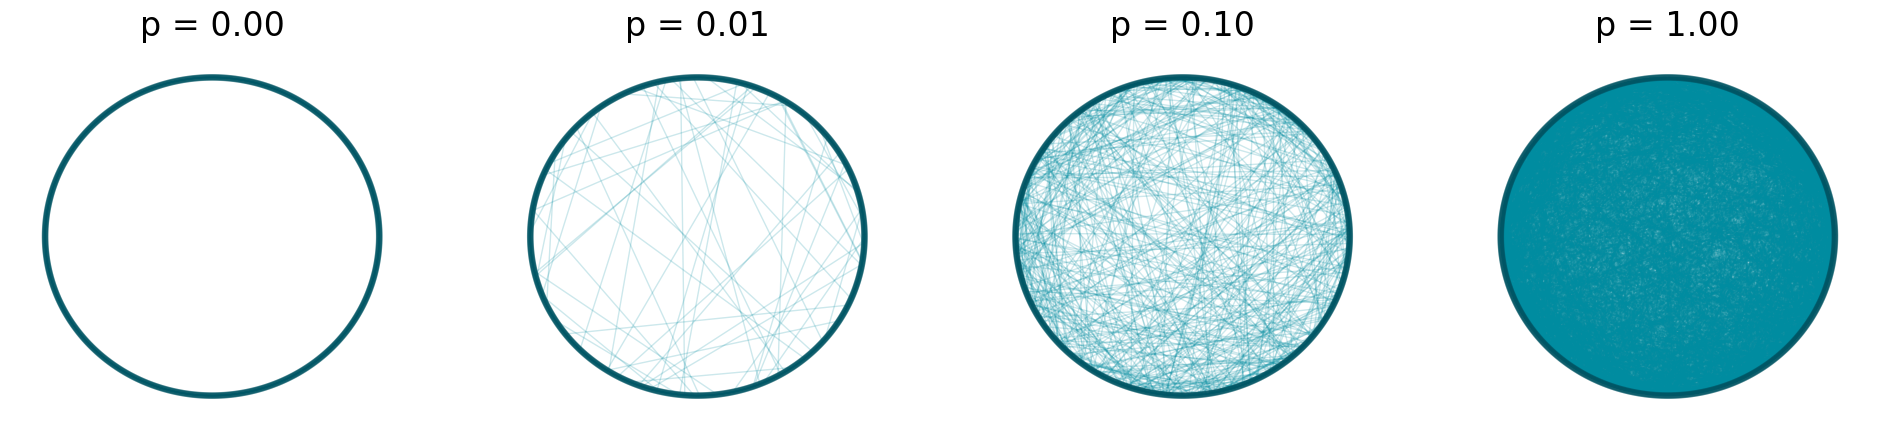

In [10]:
nb_sweep_vals = 4

sweep_vals = [0.0, 0.01, 0.1, 1]

SFig_net, axes_net = plt.subplots(1, nb_sweep_vals, figsize = (6*nb_sweep_vals, 5))
pos = {i:(np.cos(i*2*np.pi/n), np.sin(i*2*np.pi/n)) for i in range(n)}
for i, sweep_val in enumerate(sweep_vals):
    ax = axes_net[i]
    
    G = network_generator(**network_params, **{sweep_param : sweep_val})
    rng.plot_nx(G, ax = ax, pos = pos)
    ax.set_title(f'{sweep_param} = {sweep_val:.2f}', size = 24)
    
SFig_net.savefig(f'data/SFig-metric_analysis-WS_N{n}_k{k}-networks.png')
SFig_net.savefig(f'data/SFig-metric_analysis-WS_N{n}_k{k}-networks.pdf')

In [11]:
pbar = tqdm(sweep_vals, total = nb_sweep_vals)

data_dict = json_to_dictofdictoflist('', 
                                     new = True, 
                                     lambda_key2 = float)
for sweep_val in pbar:
    update_data_dict(data_dict = data_dict,
                     network_generator = network_generator, 
                     network_params = network_params, 
                     sweep_val = sweep_val,
                     sweep_param = sweep_param,
                     point_cloud = False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:21<00:00, 50.30s/it]


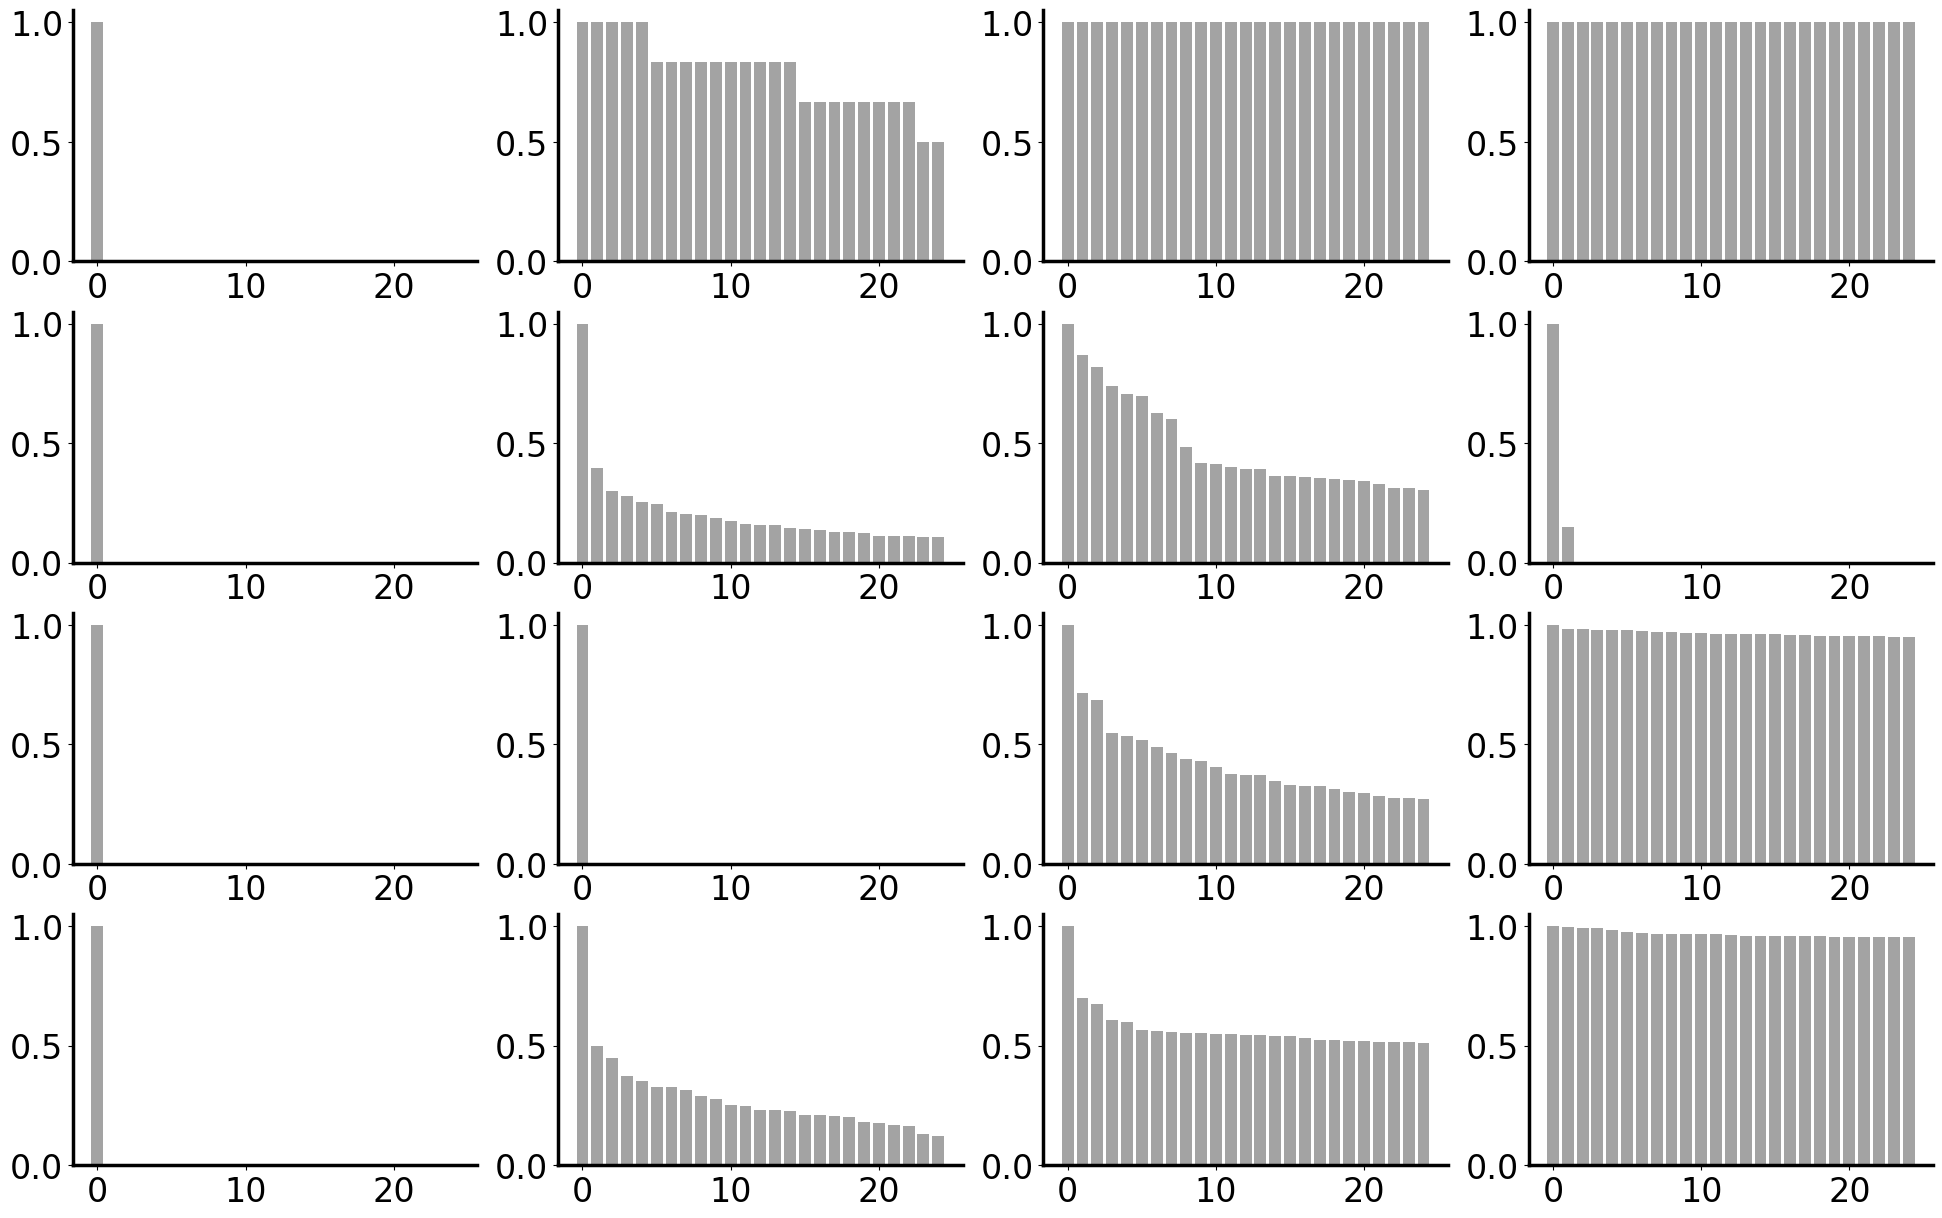

In [12]:
SFig_seq, axes_seq = plt.subplots(len(METRICS), nb_sweep_vals, figsize = (6*nb_sweep_vals, 15))
for (i, sweep_val), (j, metric) in product(enumerate(sweep_vals), enumerate(METRICS)):
    ax = axes_seq[j,i]
    pdgm = data_dict[metric][sweep_val][0].trimmed(25)
    rng.plot_seq(pdgm, ax = ax)

SFig_seq.savefig(f'data/SFig-metric_analysis-WS_N{n}_k{k}-persistent_sequences.png')
SFig_seq.savefig(f'data/SFig-metric_analysis-WS_N{n}_k{k}-persistent_sequences.pdf')

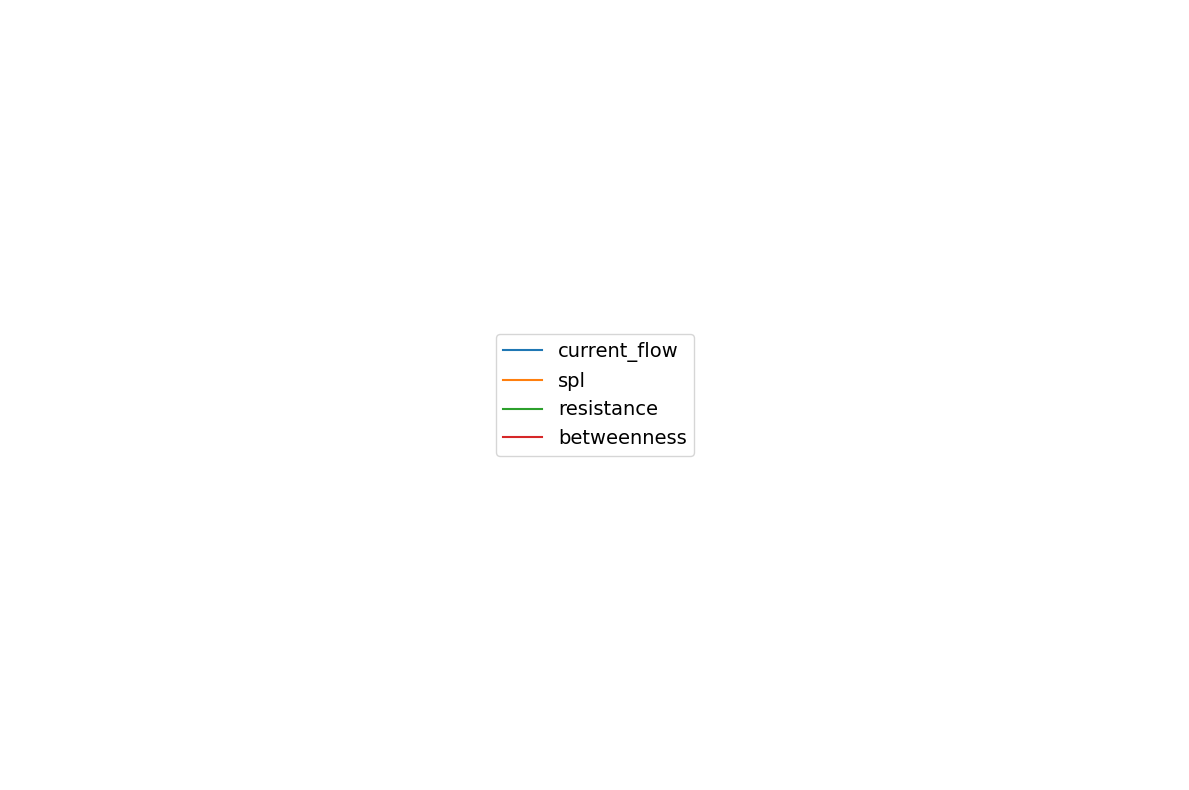

In [13]:
SFig_leg, ax_leg = plt.subplots(figsize = (12,8))

for metric in ['current_flow', 'spl', 'resistance', 'betweenness']:
    ax_leg.plot([],[],label = metric)

ax_leg.set_axis_off()
leg = ax_leg.legend(fontsize = 14, loc = 'center')
SFig_leg.tight_layout()
    
SFig_leg.savefig(f'data/SFig-metric_analysis-WS_N{n}_k{k}-legend.png')
SFig_leg.savefig(f'data/SFig-metric_analysis-WS_N{n}_k{k}-legend.pdf')

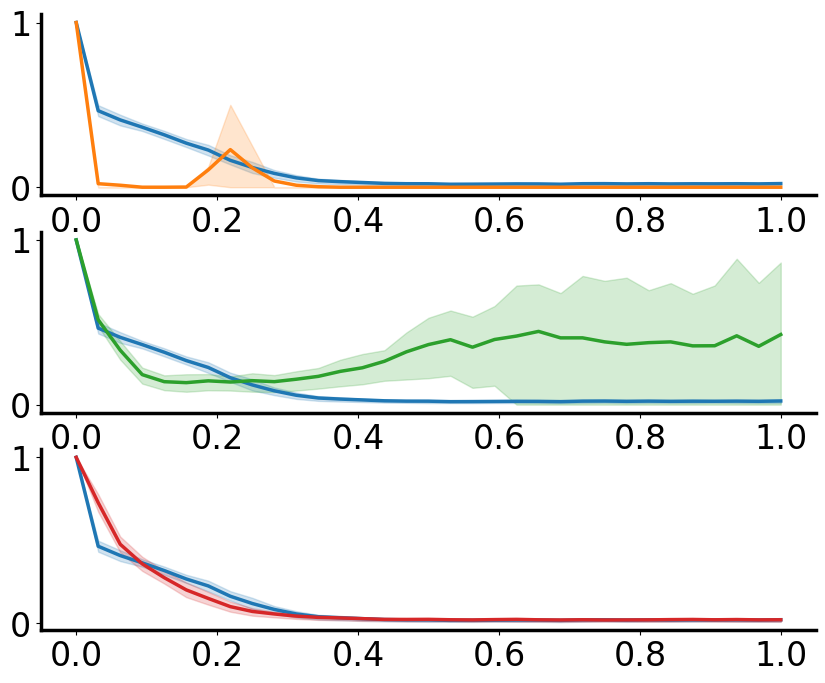

In [14]:
SFig_score, axes_score = plt.subplots(len(METRICS) - 1, figsize = (10,8))

for i, metric in enumerate(METRICS[:-1]):
    curr_plot_data = plot_data[plot_data.metric.isin({'current_flow', metric})].copy()
    curr_plot_data.order = 2
    curr_plot_data.loc[curr_plot_data.metric == 'current_flow', 'order'] = 1
    curr_plot_data = curr_plot_data.sort_values('order')
    ax = axes_score[i]
    ax = sns.lineplot(data = curr_plot_data, 
                      x = sweep_param, 
                      y = 'scores', 
                      hue = 'metric', 
                      linewidth = 2.5,
                      errorbar = ('pi', 50),
                      palette = [PALETTE[0], PALETTE[i+1]],
                      ax = ax)

    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.legend([], [], frameon = False)
    rng.plotting.styling.ax_setup(ax)
    
SFig_score.savefig(f'data/SFig-metric_analysis-WS_N{n}_k{k}-score_curves.png')
SFig_score.savefig(f'data/SFig-metric_analysis-WS_N{n}_k{k}-score_curves.pdf')

---

# Random Geometric Graphs 

## Growing cylinder

### Set Parameters

In [4]:
# Network parameters
n = 1000
k = 10

sweep_param = 'height'
nb_sweep_vals = 2**5 + 1
min_sweep_val = 0
max_sweep_val = 10

network_generator = knn_cylinder
network_params = {'n':n, 'k':k}

fname_data = Path(f'../../../data/pdgms-extending_cylinder-KNN-n{n}_k{k}.json')

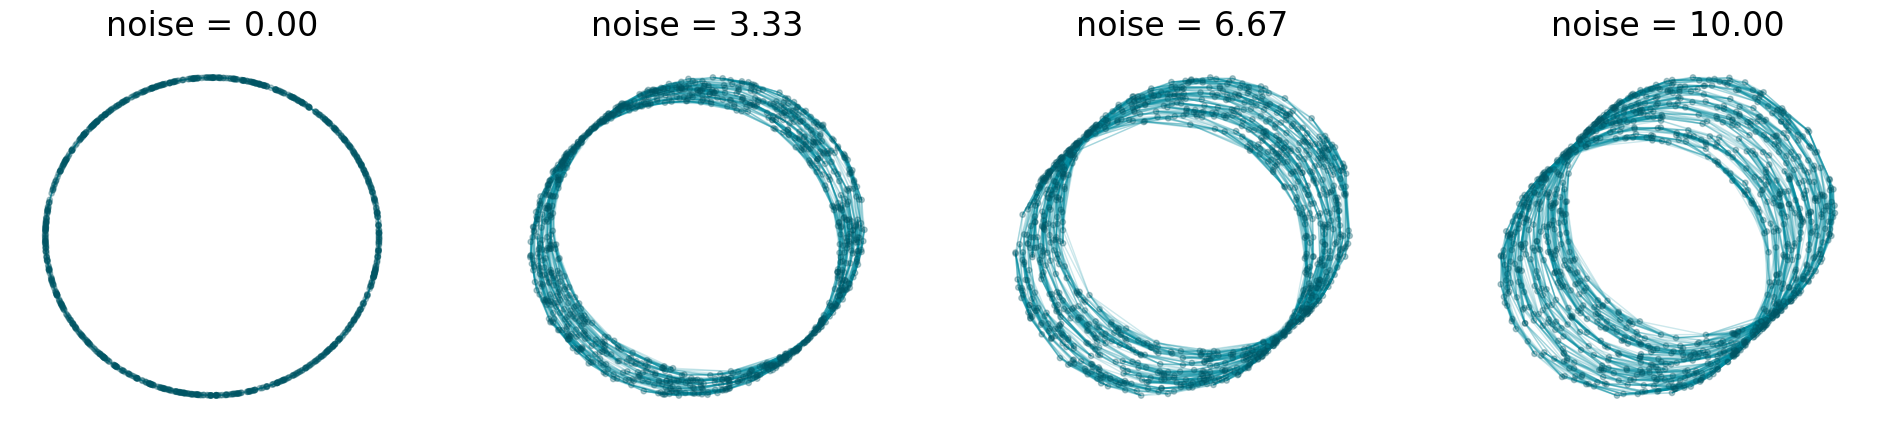

In [5]:
nb_plots = 4

sweep_vals = np.linspace(min_sweep_val, max_sweep_val, nb_plots)

fig, axes = plt.subplots(1, nb_plots, figsize = (6*nb_plots, 5))
for i, sweep_val in enumerate(sweep_vals):
    ax = axes[i]
    G, X = network_generator(**network_params, **{sweep_param : sweep_val})
    pos = dict(enumerate([(a+c/20, b+c/20) for (a,b,c) in X]))
    rng.plot_nx(G, pos = pos, ax = ax)
    ax.set_title(f'noise = {sweep_val:.2f}', size = 24)

### Calculations

In [6]:
# Calculation parameters
nb_samples = 2**5
new_calculation = False

In [7]:
samples = range(nb_samples)
sweep_vals = np.linspace(start = min_sweep_val, 
                         stop = max_sweep_val, 
                         num = nb_sweep_vals).round(6)

total = nb_samples * nb_sweep_vals
pbar = tqdm(product(sweep_vals, samples), total = total)

data_dict = json_to_dictofdictoflist(fname_data, 
                                     new = new_calculation, 
                                     lambda_key2 = float)
for sweep_val, _ in pbar:
    update_data_dict(data_dict = data_dict,
                 network_generator = network_generator, 
                 network_params = network_params, 
                 sweep_val = sweep_val,
                 sweep_param = sweep_param,
                 point_cloud = True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1056/1056 [5:16:53<00:00, 18.01s/it]


In [8]:
data_to_json(fname_data, data_dict)

### Plotting

In [6]:
data_dict = json_to_dictofdictoflist(fname_data, lambda_key2 = float)

In [7]:
scores_df = (data_dict_to_scores_df(data_dict, key2_name = sweep_param).
                rename({'sweep' : sweep_param}, axis = 1))

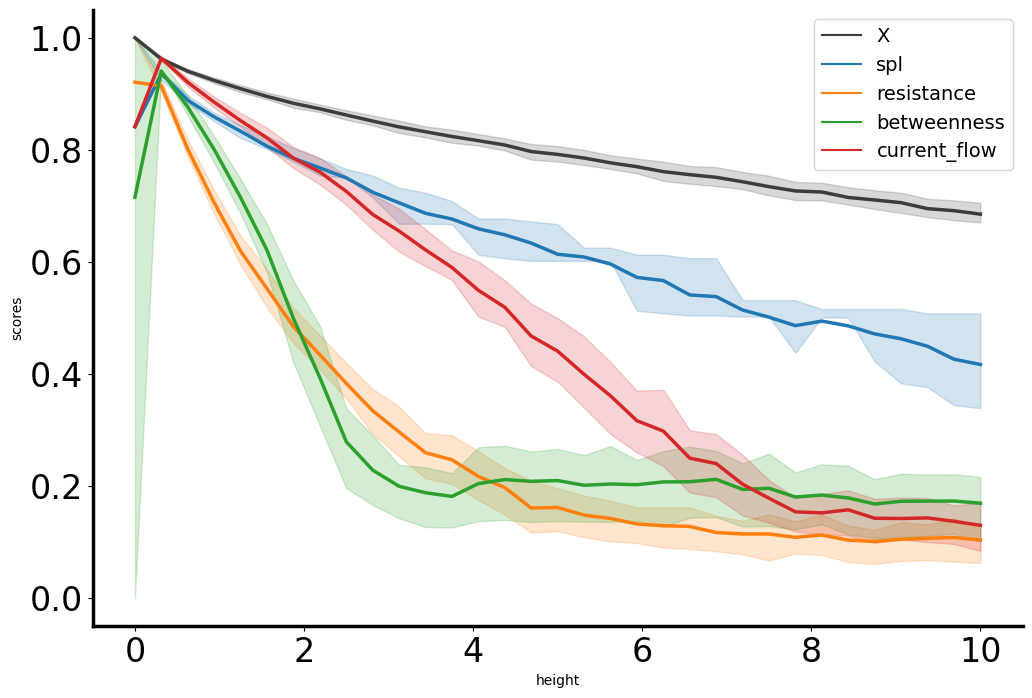

In [8]:
SFig_sum, ax_sum = plt.subplots(figsize = (12,8))

# plot_data = scores_df[scores_df.metric.isin({'X', 'spl', 'resistance'})]
plot_data = scores_df

ax_sum = sns.lineplot(data = plot_data, 
                      x = sweep_param, 
                      y = 'scores', 
                      hue = 'metric', 
                      linewidth = 2.5,
                      errorbar = ('pi', 50),
                      palette = [COLOR_X] + PALETTE,
                      ax = ax_sum)

rng.plotting.styling.ax_setup(ax_sum)

leg = ax_sum.legend(fontsize = 14)

SFig_sum.savefig(f'data/SFig-metric_analysis-extending_cylinder-KNN-n{n}_k{k}-summary.png')
SFig_sum.savefig(f'data/SFig-metric_analysis-extending_cylinder-KNN-n{n}_k{k}-summary.pdf')

### Panel plots

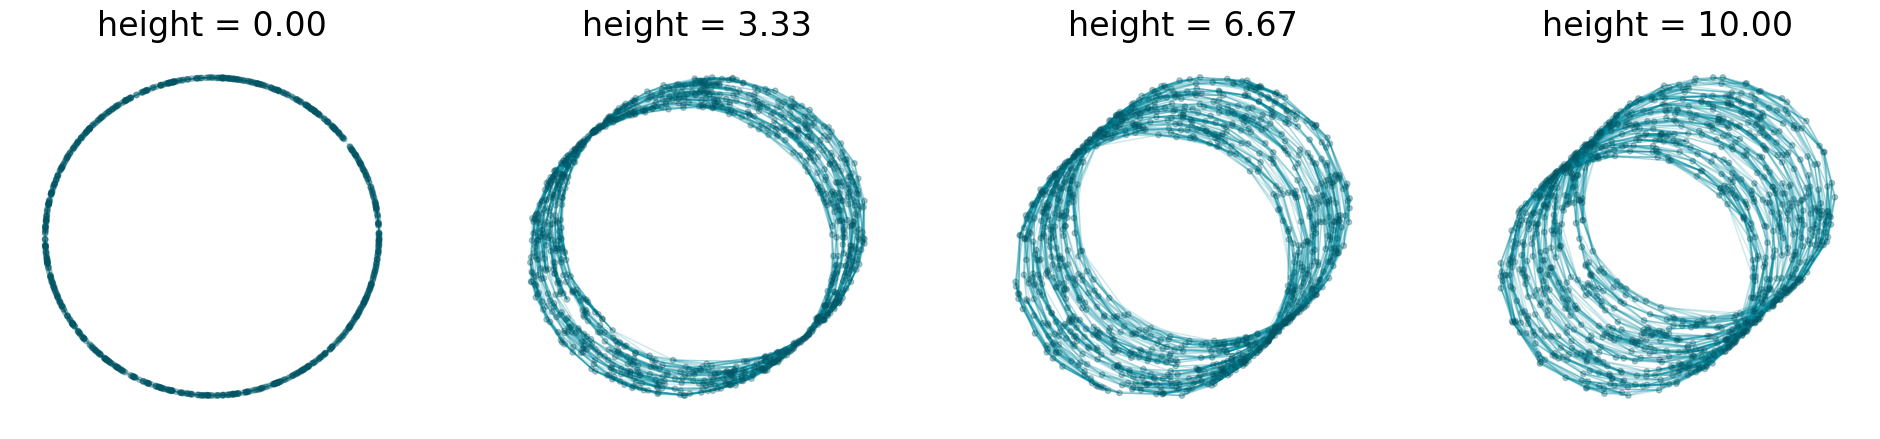

In [9]:
nb_sweep_vals = 4

sweep_vals = np.linspace(min_sweep_val, max_sweep_val, nb_sweep_vals)

SFig_net, axes_net = plt.subplots(1, nb_plots, figsize = (6*nb_sweep_vals, 5))
for i, sweep_val in enumerate(sweep_vals):
    ax = axes_net[i]
    G, X = network_generator(**network_params, **{sweep_param : sweep_val})
    pos = dict(enumerate([(a+c/15, b+c/15) for (a,b,c) in X]))
    rng.plot_nx(G, pos = pos, ax = ax)
    ax.set_title(f'height = {sweep_val:.2f}', size = 24)

    
SFig_net.savefig(f'data/SFig-metric_analysis-extending_cylinder-KNN-n{n}_k{k}-networks.png')
SFig_net.savefig(f'data/SFig-metric_analysis-extending_cylinder-KNN-n{n}_k{k}-networks.pdf')

In [10]:
pbar = tqdm(sweep_vals, total = nb_sweep_vals)

data_dict = json_to_dictofdictoflist('', 
                                     new = True, 
                                     lambda_key2 = float)
for sweep_val in pbar:
    update_data_dict(data_dict = data_dict,
                     network_generator = network_generator, 
                     network_params = network_params, 
                     sweep_val = sweep_val,
                     sweep_param = sweep_param,
                     point_cloud = True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:17<00:00, 19.48s/it]


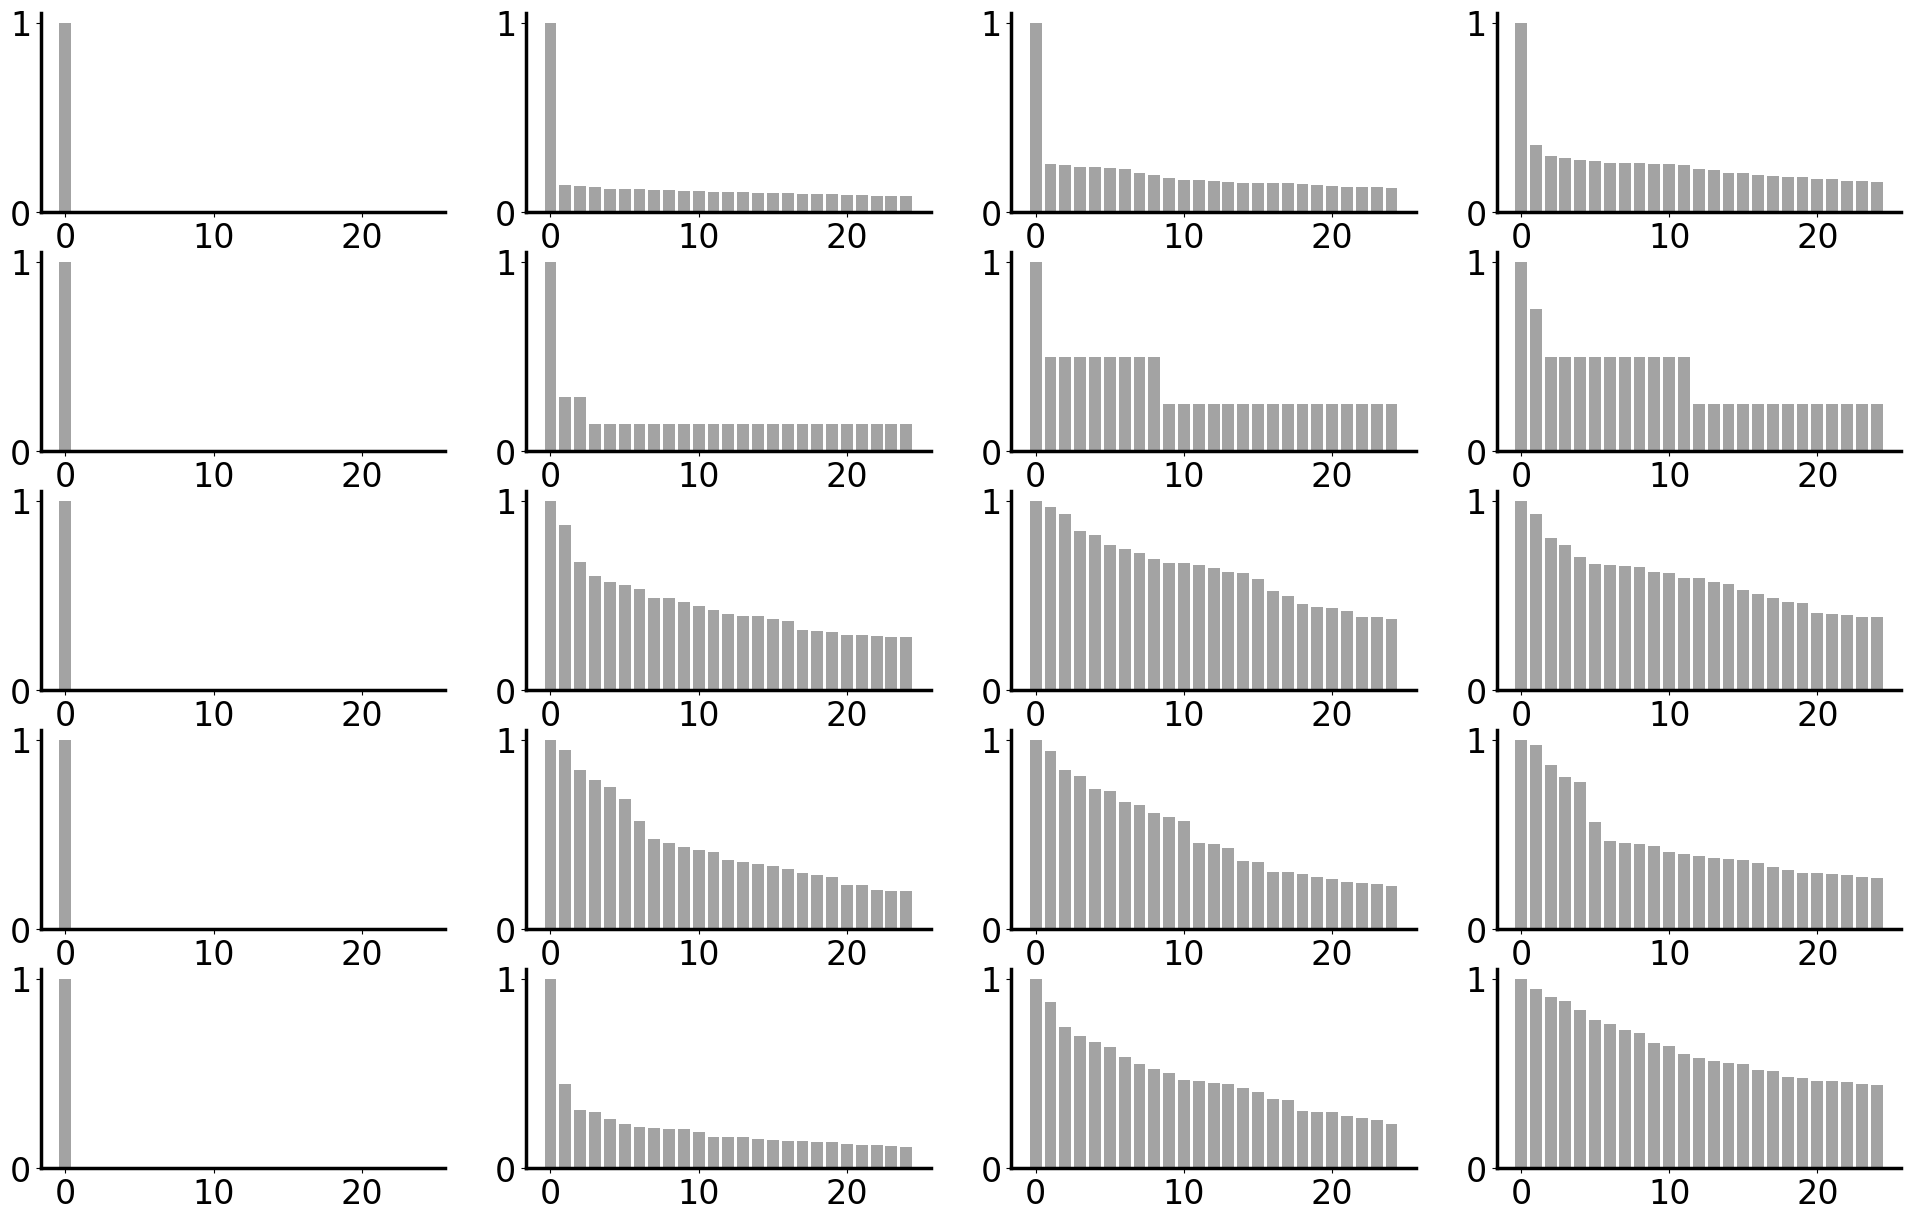

In [11]:
SFig_seq, axes_seq = plt.subplots(len(METRICS)+1, nb_sweep_vals, figsize = (6*nb_sweep_vals, 15))
for (i, sweep_val), (j, metric) in product(enumerate(sweep_vals), enumerate(['X'] + METRICS)):
    ax = axes_seq[j,i]
    pdgm = data_dict[metric][sweep_val][0].trimmed(25)
    rng.plot_seq(pdgm, ax = ax)

SFig_seq.savefig(f'data/SFig-metric_analysis-extending_cylinder-KNN-n{n}_k{k}-persistent_sequences.png')
SFig_seq.savefig(f'data/SFig-metric_analysis-extending_cylinder-KNN-n{n}_k{k}-persistent_sequences.pdf')

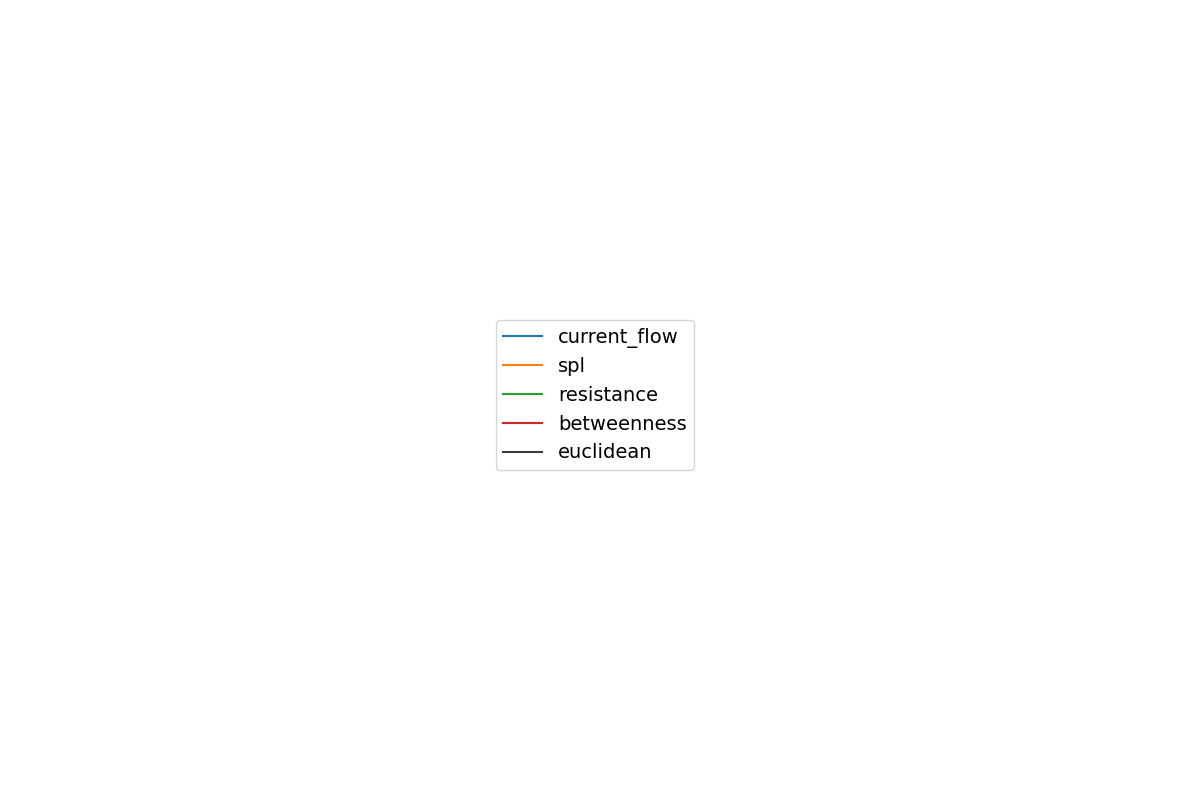

In [12]:
SFig_leg, ax_leg = plt.subplots(figsize = (12,8))

for metric in ['current_flow', 'spl', 'resistance', 'betweenness']:
    ax_leg.plot([],[],label = metric)
ax_leg.plot([],[],label = 'euclidean', color = COLOR_X)
ax_leg.set_axis_off()
leg = ax_leg.legend(fontsize = 14, loc = 'center')
SFig_leg.tight_layout()

    
SFig_leg.savefig(f'data/SFig-metric_analysis-extending_cylinder-KNN-n{n}_k{k}-legend.png')
SFig_leg.savefig(f'data/SFig-metric_analysis-extending_cylinder-KNN-n{n}_k{k}-legend.pdf')

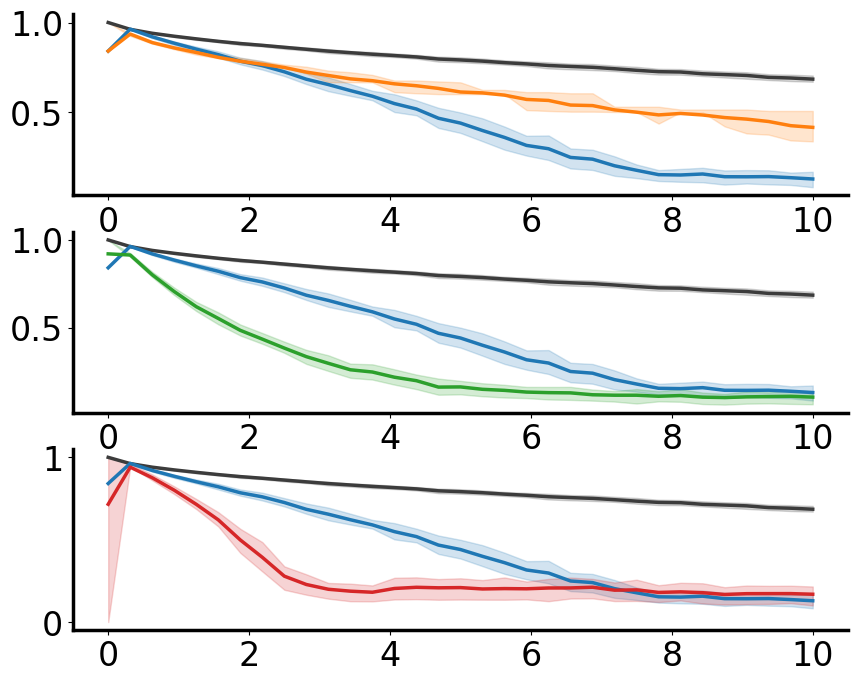

In [13]:
SFig_score, axes_score = plt.subplots(len(METRICS) - 1, figsize = (10,8))

for i, metric in enumerate(METRICS[:-1]):
    curr_plot_data = plot_data[plot_data.metric.isin({'X', 'current_flow', metric})].copy()
    curr_plot_data.order = 3
    curr_plot_data.loc[curr_plot_data.metric == 'current_flow', 'order'] = 2
    curr_plot_data.loc[curr_plot_data.metric == 'X', 'order'] = 1
    curr_plot_data = curr_plot_data.sort_values('order')
    ax = axes_score[i]
    ax = sns.lineplot(data = curr_plot_data, 
                      x = sweep_param, 
                      y = 'scores', 
                      hue = 'metric', 
                      linewidth = 2.5,
                      errorbar = ('pi', 50),
                      palette = [COLOR_X, PALETTE[0], PALETTE[i+1]],
                      ax = ax)

    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.legend([], [], frameon = False)
    rng.plotting.styling.ax_setup(ax)
    
SFig_score.savefig(f'data/SFig-metric_analysis-extending_cylinder-KNN-n{n}_k{k}-score_curves.png')
SFig_score.savefig(f'data/SFig-metric_analysis-extending_cylinder-KNN-n{n}_k{k}-score_curves.pdf')

---

## Circle with uniform noise - density cutoff

In [5]:
# Network parameters
n = 1000

sweep_param = 'perc_noise'
nb_sweep_vals = 2**5
min_sweep_val = 0
max_sweep_val = 1

network_generator = delaunay_circle
network_params = {'n' : n}

fname_data = Path(f'../../../data/pdgms-circle_with_uniform_noise-n{n}_delaunay.json')

In [5]:
# Network parameters
n = 1000
k = 10

sweep_param = 'perc_noise'
nb_sweep_vals = 2**5
min_sweep_val = 0
max_sweep_val = 1

network_generator = knn_circle
network_params = {'n':n, 'k':k}

fname_data = Path(f'../../../data/pdgms-circle_with_uniform_noise-n{n}_k{k}_KNN.json')

In [6]:
# # Network parameters
# n = 1000
# k = 10
# er_fc_th = 10
# # density_th = k/(n-1)

# sweep_param = 'perc_noise'
# nb_sweep_vals = 2**5
# min_sweep_val = 0
# max_sweep_val = 1

# network_generator = circle_with_uniform_noise
# # network_params = {'n' : n, 'density_th' : density_th}
# # fname_data = Path(f'../../../data/pdgms-circle_with_uniform_noise-n{n}_density{density_th}.json')

# # We choose this threshold to ensure connectedness!
# network_params = {'n' : n, 'er_fc_th' : er_fc_th} 
# fname_data = Path(f'../../../data/pdgms-circle_with_uniform_noise-n{n}_erfc{er_fc_th}.json')

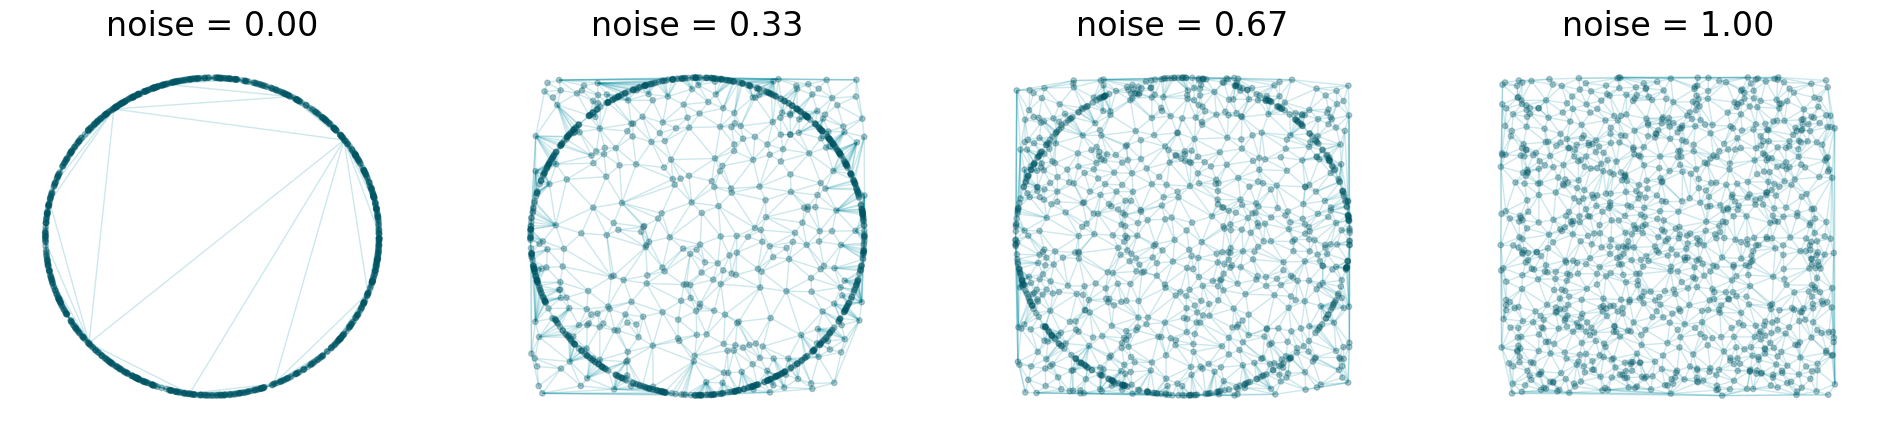

In [6]:
nb_plots = 4

sweep_vals = np.linspace(min_sweep_val, max_sweep_val, nb_plots)

fig, axes = plt.subplots(1, nb_plots, figsize = (6*nb_plots, 5))
for i, sweep_val in enumerate(sweep_vals):
    ax = axes[i]
    G, X = network_generator(**network_params, **{sweep_param : sweep_val})
    pos = dict(enumerate(X))
    rng.plot_nx(G, pos = pos, ax = ax)
    ax.set_title(f'noise = {sweep_val:.2f}', size = 24)

### Calculations

In [9]:
# Calculation parameters
nb_samples = 2**3
new_calculation = False

In [19]:
samples = range(nb_samples)
sweep_vals = np.linspace(start = min_sweep_val, 
                         stop = max_sweep_val, 
                         num = nb_sweep_vals).round(6)

total = nb_samples * nb_sweep_vals
pbar = tqdm(product(sweep_vals, samples), total = total)

data_dict = json_to_dictofdictoflist(fname_data, 
                                     new = new_calculation, 
                                     lambda_key2 = float)
for sweep_val, _ in pbar:
    update_data_dict(data_dict = data_dict,
                     network_generator = network_generator, 
                     network_params = network_params, 
                     sweep_val = sweep_val,
                     sweep_param = sweep_param,
                     point_cloud = True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [05:37<00:00,  1.32s/it]


In [21]:
data_to_json(fname_data, data_dict)

### Plotting

In [22]:
data_dict = json_to_dictofdictoflist(fname_data, lambda_key2 = float)

In [23]:
scores_df = (data_dict_to_scores_df(data_dict, key2_name = sweep_param).
                rename({'sweep' : sweep_param}, axis = 1))

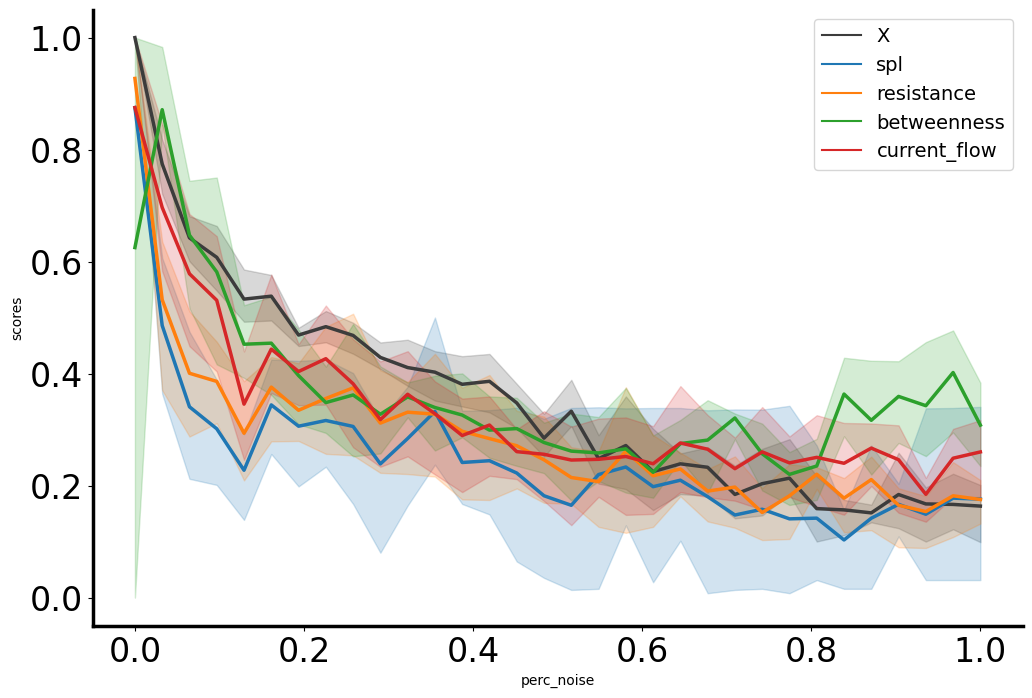

In [24]:
fig, ax = plt.subplots(figsize = (12,8))

# plot_data = scores_df[scores_df.metric.isin({'X', 'spl', 'resistance'})]
plot_data = scores_df

ax = sns.lineplot(data = plot_data, 
                  x = sweep_param, 
                  y = 'scores', 
                  hue = 'metric', 
                  linewidth = 2.5,
                  errorbar = ('pi', 50),
                  palette = [COLOR_X] + PALETTE,
                  ax = ax)

rng.plotting.styling.ax_setup(ax)

leg = ax.legend(fontsize = 14)

# fig.savefig('plots/direct_metrics_noisy_circle.png')
# fig.savefig('plots/direct_metrics_noisy_circle.pdf')

### Panel plot

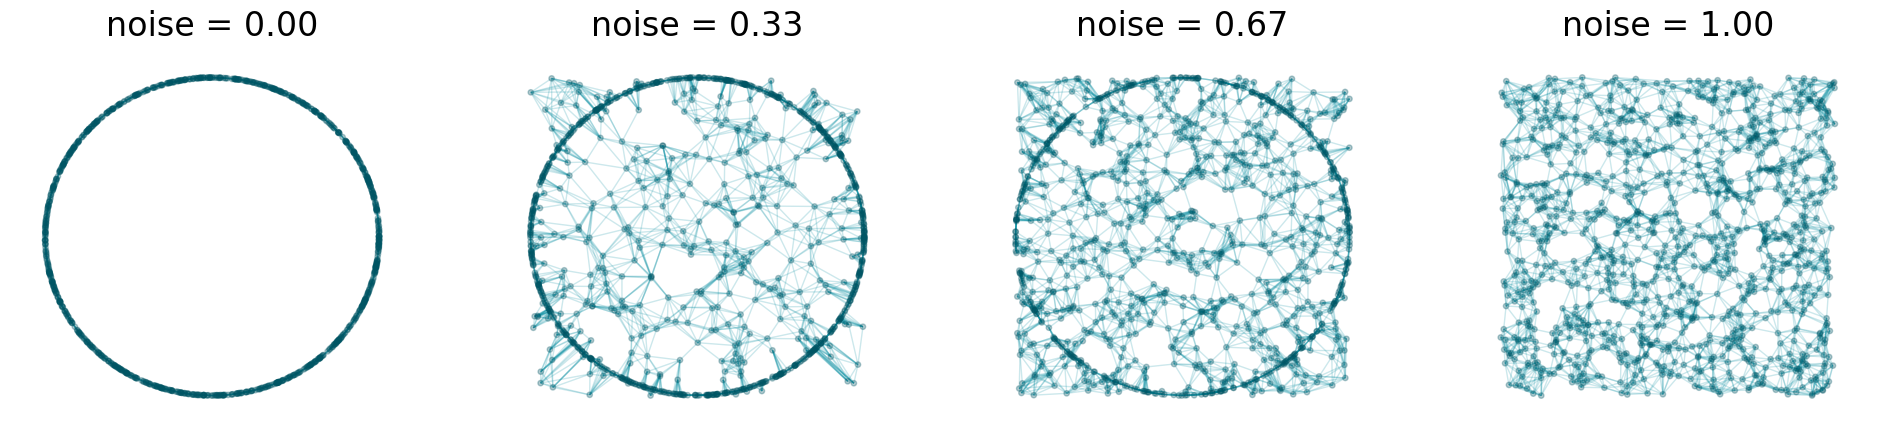

In [25]:
nb_sweep_vals = 4

sweep_vals = np.linspace(min_sweep_val, max_sweep_val, nb_plots)

A_fig, A_axes = plt.subplots(1, nb_sweep_vals, figsize = (6*nb_sweep_vals, 5))
for i, sweep_val in enumerate(sweep_vals):
    ax = A_axes[i]
    G, X = network_generator(**network_params, **{sweep_param : sweep_val})
    pos = dict(enumerate(X))
    rng.plot_nx(G, pos = pos, ax = ax)
    ax.set_title(f'noise = {sweep_val:.2f}', size = 24)
    
A_fig.savefig('data/Sfig-metric_analysis_2-A.png')
A_fig.savefig('data/Sfig-metric_analysis_2-A.pdf')

In [26]:
pbar = tqdm(sweep_vals, total = nb_sweep_vals)

data_dict = json_to_dictofdictoflist('', 
                                     new = True, 
                                     lambda_key2 = float)
for sweep_val in pbar:
    update_data_dict(data_dict = data_dict,
                     network_generator = network_generator, 
                     network_params = network_params, 
                     sweep_val = sweep_val,
                     sweep_param = sweep_param,
                     point_cloud = True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:03<00:00, 15.92s/it]


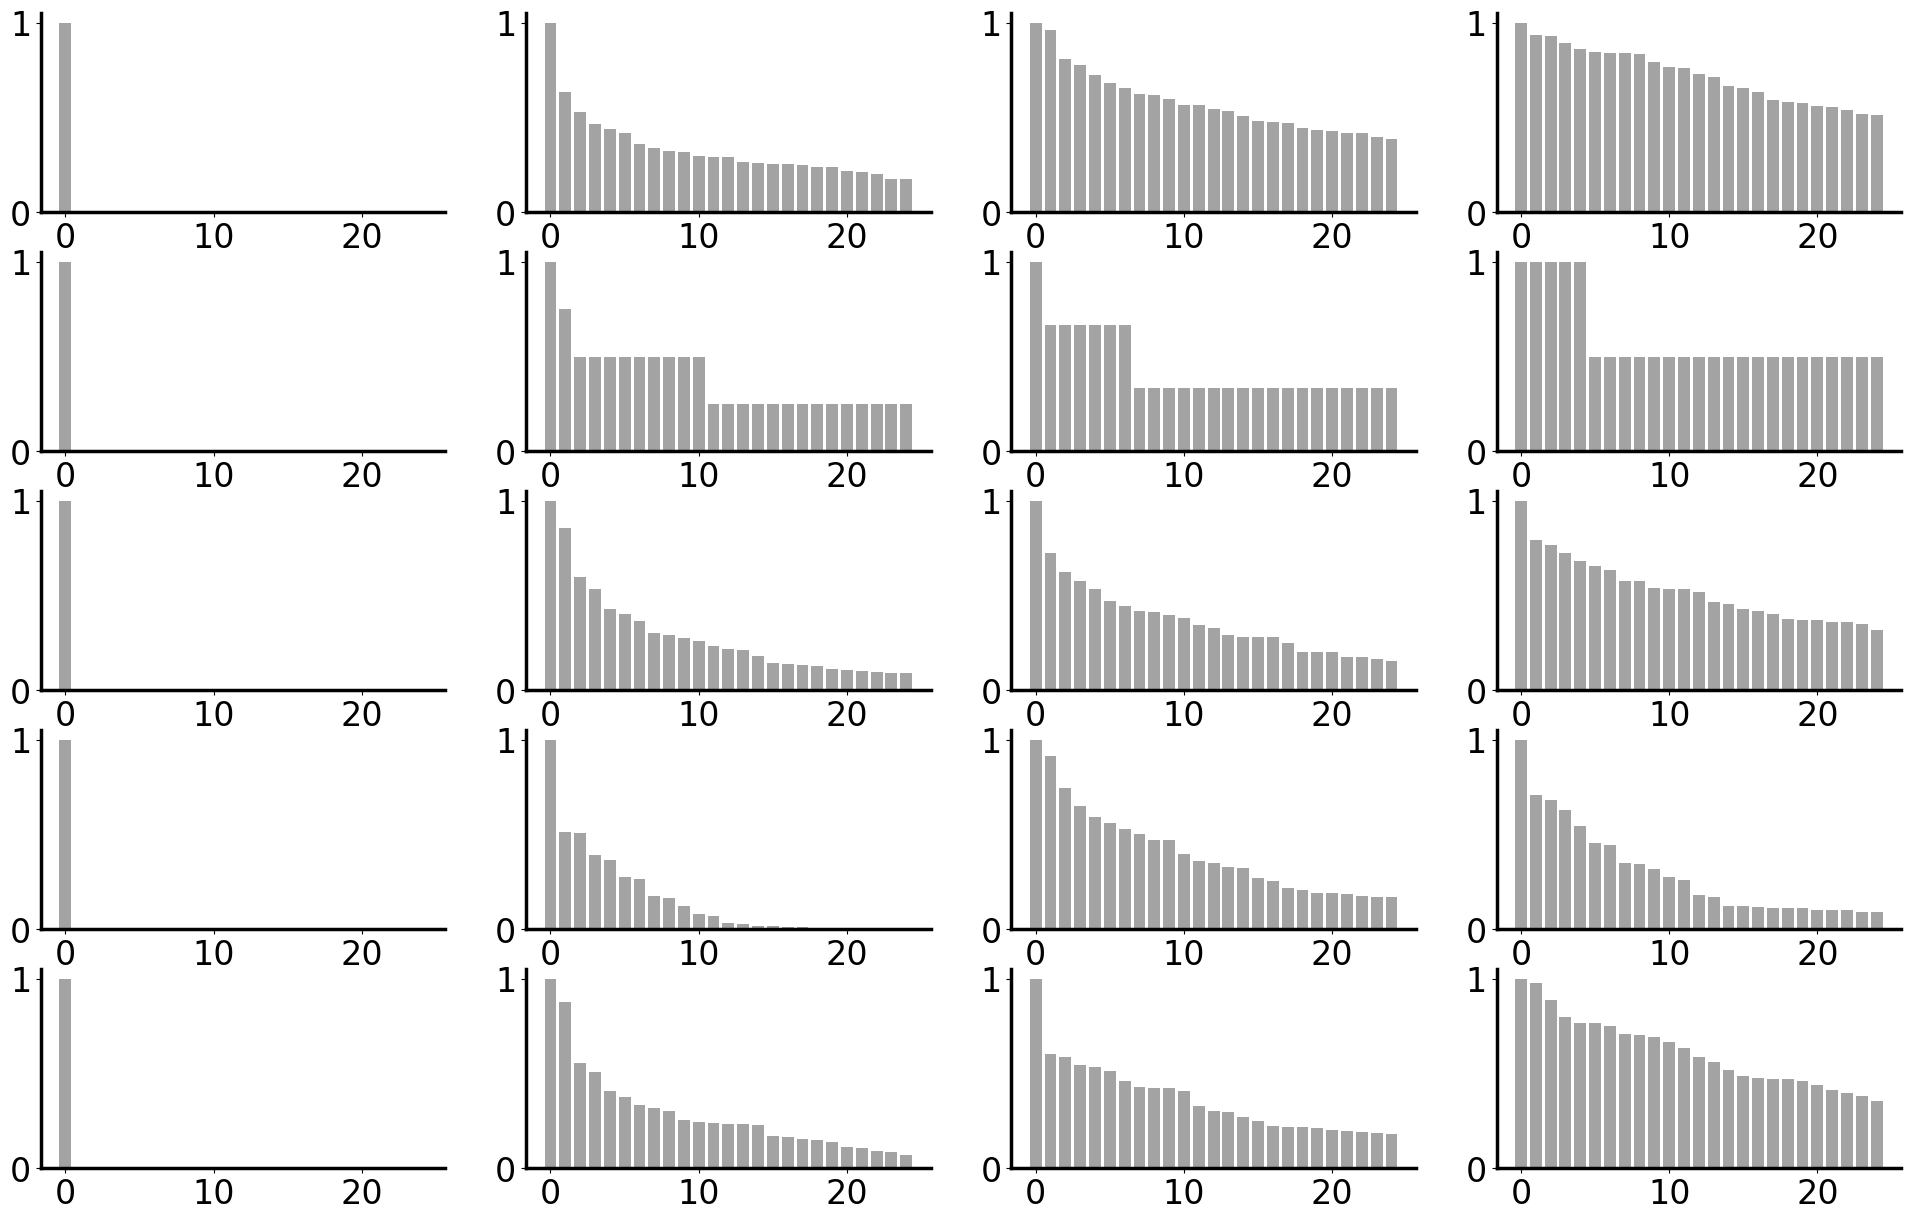

In [27]:
B_fig, B_axes = plt.subplots(len(METRICS)+1, nb_sweep_vals, figsize = (6*nb_sweep_vals, 15))
for (i, sweep_val), (j, metric) in product(enumerate(sweep_vals), enumerate(['X'] + METRICS)):
    ax = B_axes[j,i]
    pdgm = data_dict[metric][sweep_val][0].trimmed(25)
    rng.plot_seq(pdgm, ax = ax)

B_fig.savefig('data/Sfig-metric_analysis_2-B.png')
B_fig.savefig('data/Sfig-metric_analysis_2-B.pdf')

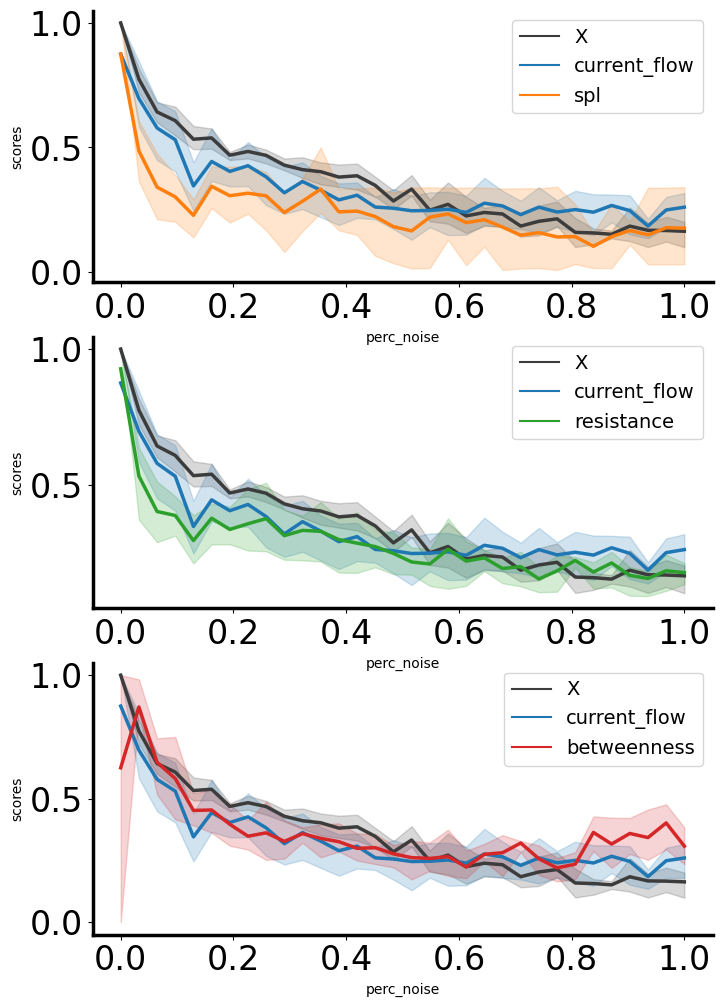

In [28]:
C_fig, C_axes = plt.subplots(len(METRICS) - 1, figsize = (8,12))

for i, metric in enumerate(METRICS[:-1]):
    curr_plot_data = plot_data[plot_data.metric.isin({'X', 'current_flow', metric})].copy()
    curr_plot_data.order = 3
    curr_plot_data.loc[curr_plot_data.metric == 'current_flow', 'order'] = 2
    curr_plot_data.loc[curr_plot_data.metric == 'X', 'order'] = 1
    curr_plot_data = curr_plot_data.sort_values('order')
    ax = C_axes[i]
    ax = sns.lineplot(data = curr_plot_data, 
                      x = sweep_param, 
                      y = 'scores', 
                      hue = 'metric', 
                      linewidth = 2.5,
                      errorbar = ('pi', 50),
                      palette = [COLOR_X, PALETTE[0], PALETTE[i+1]],
                      ax = ax)

    rng.plotting.styling.ax_setup(ax)
    leg = ax.legend(fontsize = 14)

plt.show()
    
C_fig.savefig('data/Sfig-metric_analysis_2-C.png')
C_fig.savefig('data/Sfig-metric_analysis_2-C.pdf')

---

## Noisy circle - robustness on node level: $\sigma \approx 1-c$

## Growing cylinder

In [5]:
def delaunay_cylinder(n, height,
                      seed = None,
                      **network_params):
    X = rgeom.point_clouds.cylinder(N = n, height = height, seed = seed)
    X += np.random.normal(scale = 2**(-10), size = X.shape)
    G = delaunay_graph(X)
    return G, X

def knn_cylinder(n, height,
                 seed = None,
                 **network_params):
    X = rgeom.point_clouds.cylinder(N = n, height = height, seed = seed)
    X += np.random.normal(scale = 2**(-10), size = X.shape)
    G = knn_graph(X, k)
    return G, X

def knn_density(n, height,
                 seed = None,
                 **network_params):
    X = rgeom.point_clouds.cylinder(N = n, height = height, seed = seed)
    X += np.random.normal(scale = 2**(-10), size = X.shape)
    G = rgeom.pointcloud_to_graph(X, **network_params)
    return G, X

### Set Parameters

In [6]:
# # Network parameters
# n = 1000
# k = 10

# sweep_param = 'height'
# nb_sweep_vals = 2**5
# min_sweep_val = 0
# max_sweep_val = 10

# network_generator = knn_cylinder
# network_params = {'n':n, 'k':k}

# fname_data = Path(f'../../../data/pdgms-extending_cylinder-KNN-n{n}.json')

In [7]:
# # Network parameters
# n = 1000

# sweep_param = 'height'
# nb_sweep_vals = 2**5
# min_sweep_val = 0
# max_sweep_val = 10

# network_generator = delaunay_cylinder
# network_params = {'n' : n}

# fname_data = Path(f'../../../data/pdgms-extending_cylinder-delaunay-n{n}.json')

In [8]:
# Network parameters
n = 1000
k = 10
density_th = k/(n-1)

sweep_param = 'height'
nb_sweep_vals = 2**5
min_sweep_val = 0
max_sweep_val = 10

network_generator = knn_density
network_params = {'n' : n, 'density_th' : density_th}
fname_data = Path(f'../../../data/pdgms-extending_cylinder-n{n}_density{density_th}.json')

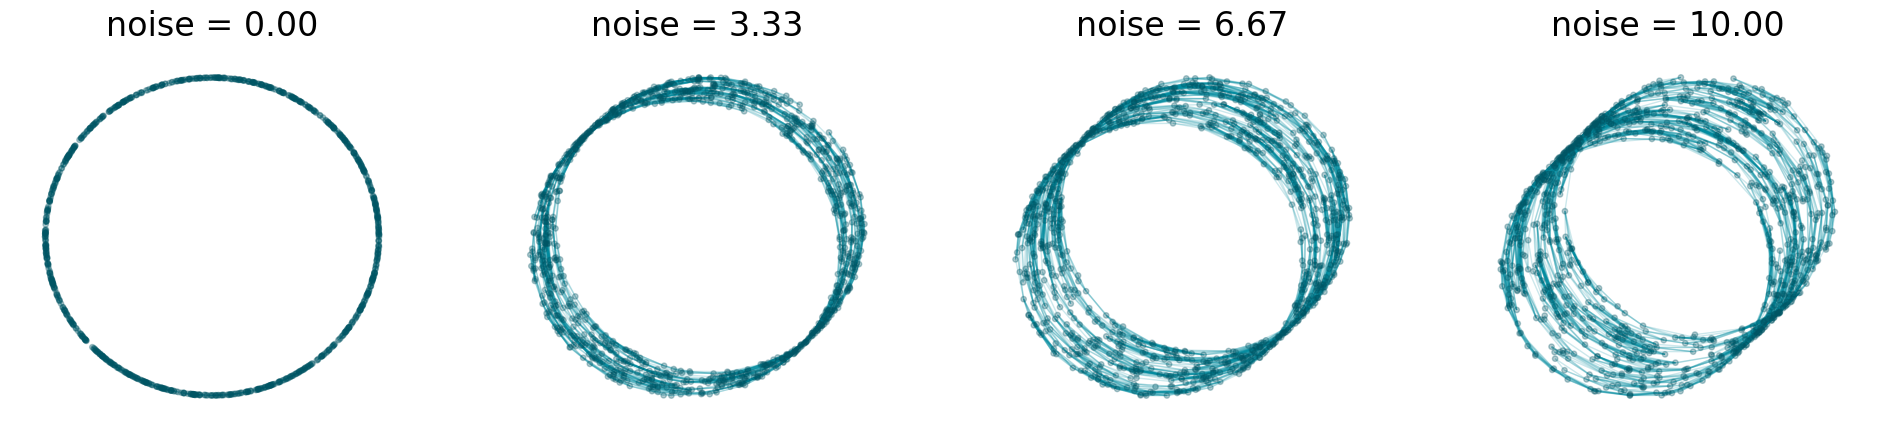

In [ ]:
nb_plots = 4

sweep_vals = np.linspace(min_sweep_val, max_sweep_val, nb_plots)

fig, axes = plt.subplots(1, nb_plots, figsize = (6*nb_plots, 5))
for i, sweep_val in enumerate(sweep_vals):
    ax = axes[i]
    G, X = network_generator(**network_params, **{sweep_param : sweep_val})
    pos = dict(enumerate([(a+c/20, b+c/20) for (a,b,c) in X]))
    rng.plot_nx(G, pos = pos, ax = ax)
    ax.set_title(f'noise = {sweep_val:.2f}', size = 24)

### Calculations

In [ ]:
# Calculation parameters
nb_samples = 2**6
new_calculation = False

In [ ]:
samples = range(nb_samples)
sweep_vals = np.linspace(start = min_sweep_val, 
                         stop = max_sweep_val, 
                         num = nb_sweep_vals).round(6)

total = nb_samples * nb_sweep_vals
pbar = tqdm(product(sweep_vals, samples), total = total)

data_dict = json_to_dictofdictoflist(fname_data, 
                                     new = new_calculation, 
                                     lambda_key2 = float)
for sweep_val, _ in pbar:
    update_data_dict(data_dict = data_dict,
                 network_generator = network_generator, 
                 network_params = network_params, 
                 sweep_val = sweep_val,
                 sweep_param = sweep_param,
                 point_cloud = True)

  0%|▎                                                                                                                                                                           | 4/2048 [01:15<10:26:50, 18.40s/it]

In [ ]:
data_to_json(fname_data, data_dict)

### Plotting

In [13]:
data_dict = json_to_dictofdictoflist(fname_data, lambda_key2 = float)

In [14]:
scores_df = (data_dict_to_scores_df(data_dict, key2_name = sweep_param).
                rename({'sweep' : sweep_param}, axis = 1))

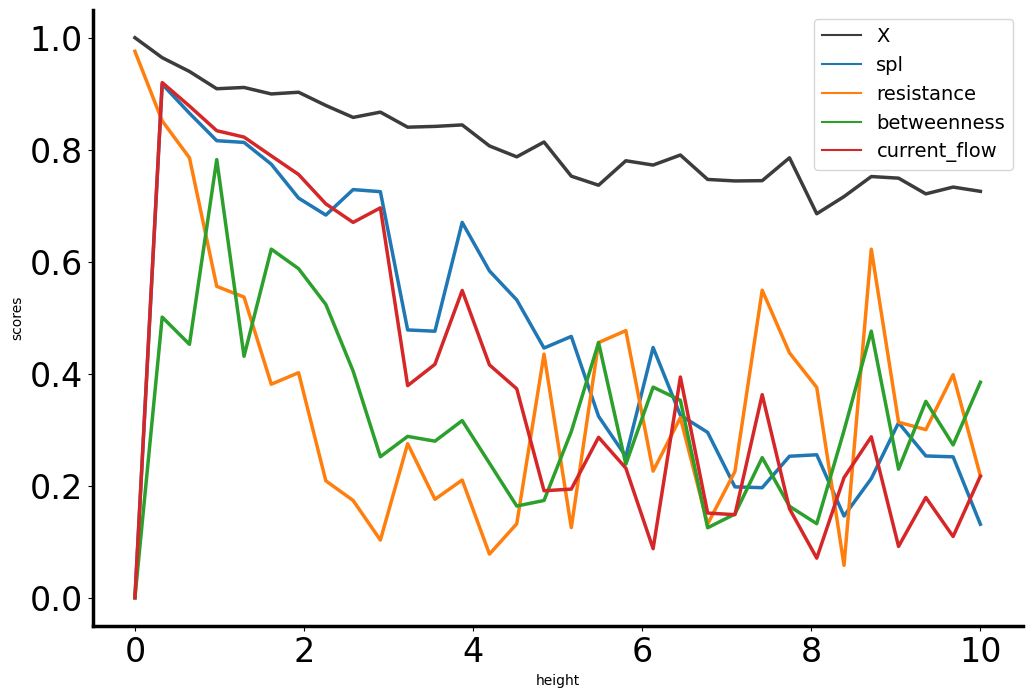

In [15]:
fig, ax = plt.subplots(figsize = (12,8))

# plot_data = scores_df[scores_df.metric.isin({'X', 'spl', 'resistance'})]
plot_data = scores_df

ax = sns.lineplot(data = plot_data, 
                  x = sweep_param, 
                  y = 'scores', 
                  hue = 'metric', 
                  linewidth = 2.5,
                  errorbar = ('pi', 50),
                  palette = [COLOR_X] + PALETTE,
                  ax = ax)

rng.plotting.styling.ax_setup(ax)

leg = ax.legend(fontsize = 14)

# fig.savefig('plots/direct_metrics_noisy_circle.png')
# fig.savefig('plots/direct_metrics_noisy_circle.pdf')

### Panel plots

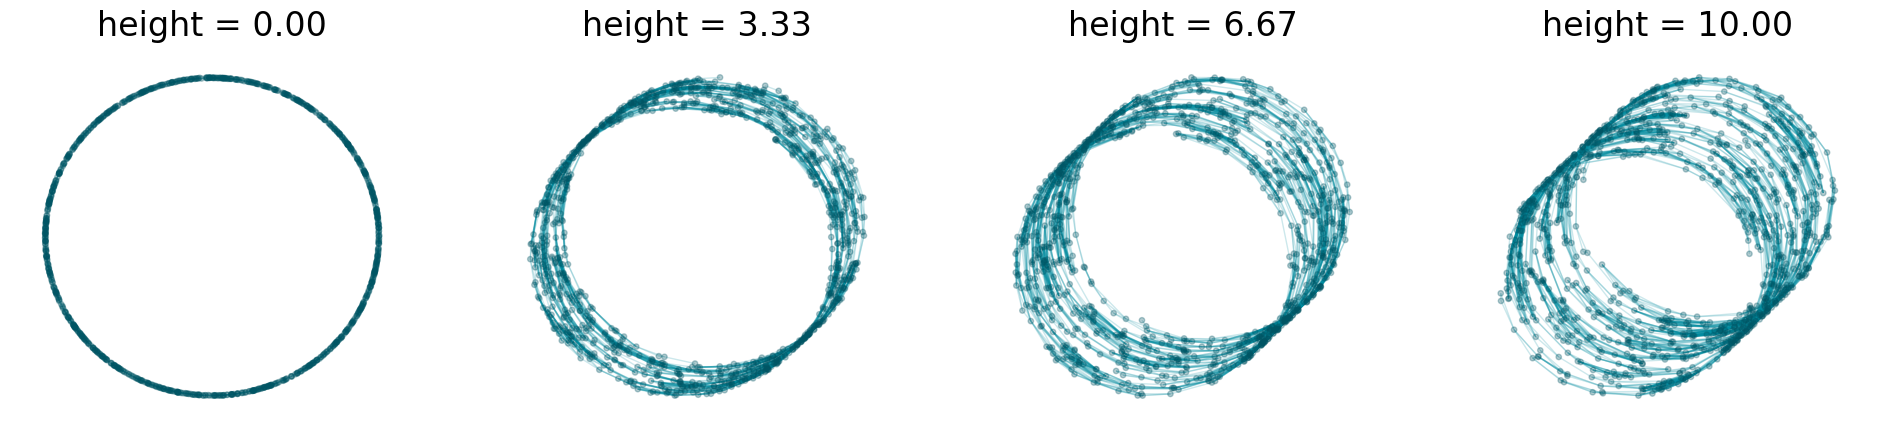

In [16]:
nb_sweep_vals = 4

sweep_vals = np.linspace(min_sweep_val, max_sweep_val, nb_sweep_vals)

A_fig, A_axes = plt.subplots(1, nb_plots, figsize = (6*nb_sweep_vals, 5))
for i, sweep_val in enumerate(sweep_vals):
    ax = A_axes[i]
    G, X = network_generator(**network_params, **{sweep_param : sweep_val})
    pos = dict(enumerate([(a+c/15, b+c/15) for (a,b,c) in X]))
    rng.plot_nx(G, pos = pos, ax = ax)
    ax.set_title(f'height = {sweep_val:.2f}', size = 24)

    
A_fig.savefig('data/Sfig-metric_analysis_3-A.png')
A_fig.savefig('data/Sfig-metric_analysis_3-A.pdf')

In [17]:
pbar = tqdm(sweep_vals, total = nb_sweep_vals)

data_dict = json_to_dictofdictoflist('', 
                                     new = True, 
                                     lambda_key2 = float)
for sweep_val in pbar:
    update_data_dict(data_dict = data_dict,
                     network_generator = network_generator, 
                     network_params = network_params, 
                     sweep_val = sweep_val,
                     sweep_param = sweep_param,
                     point_cloud = True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:52<00:00, 13.20s/it]


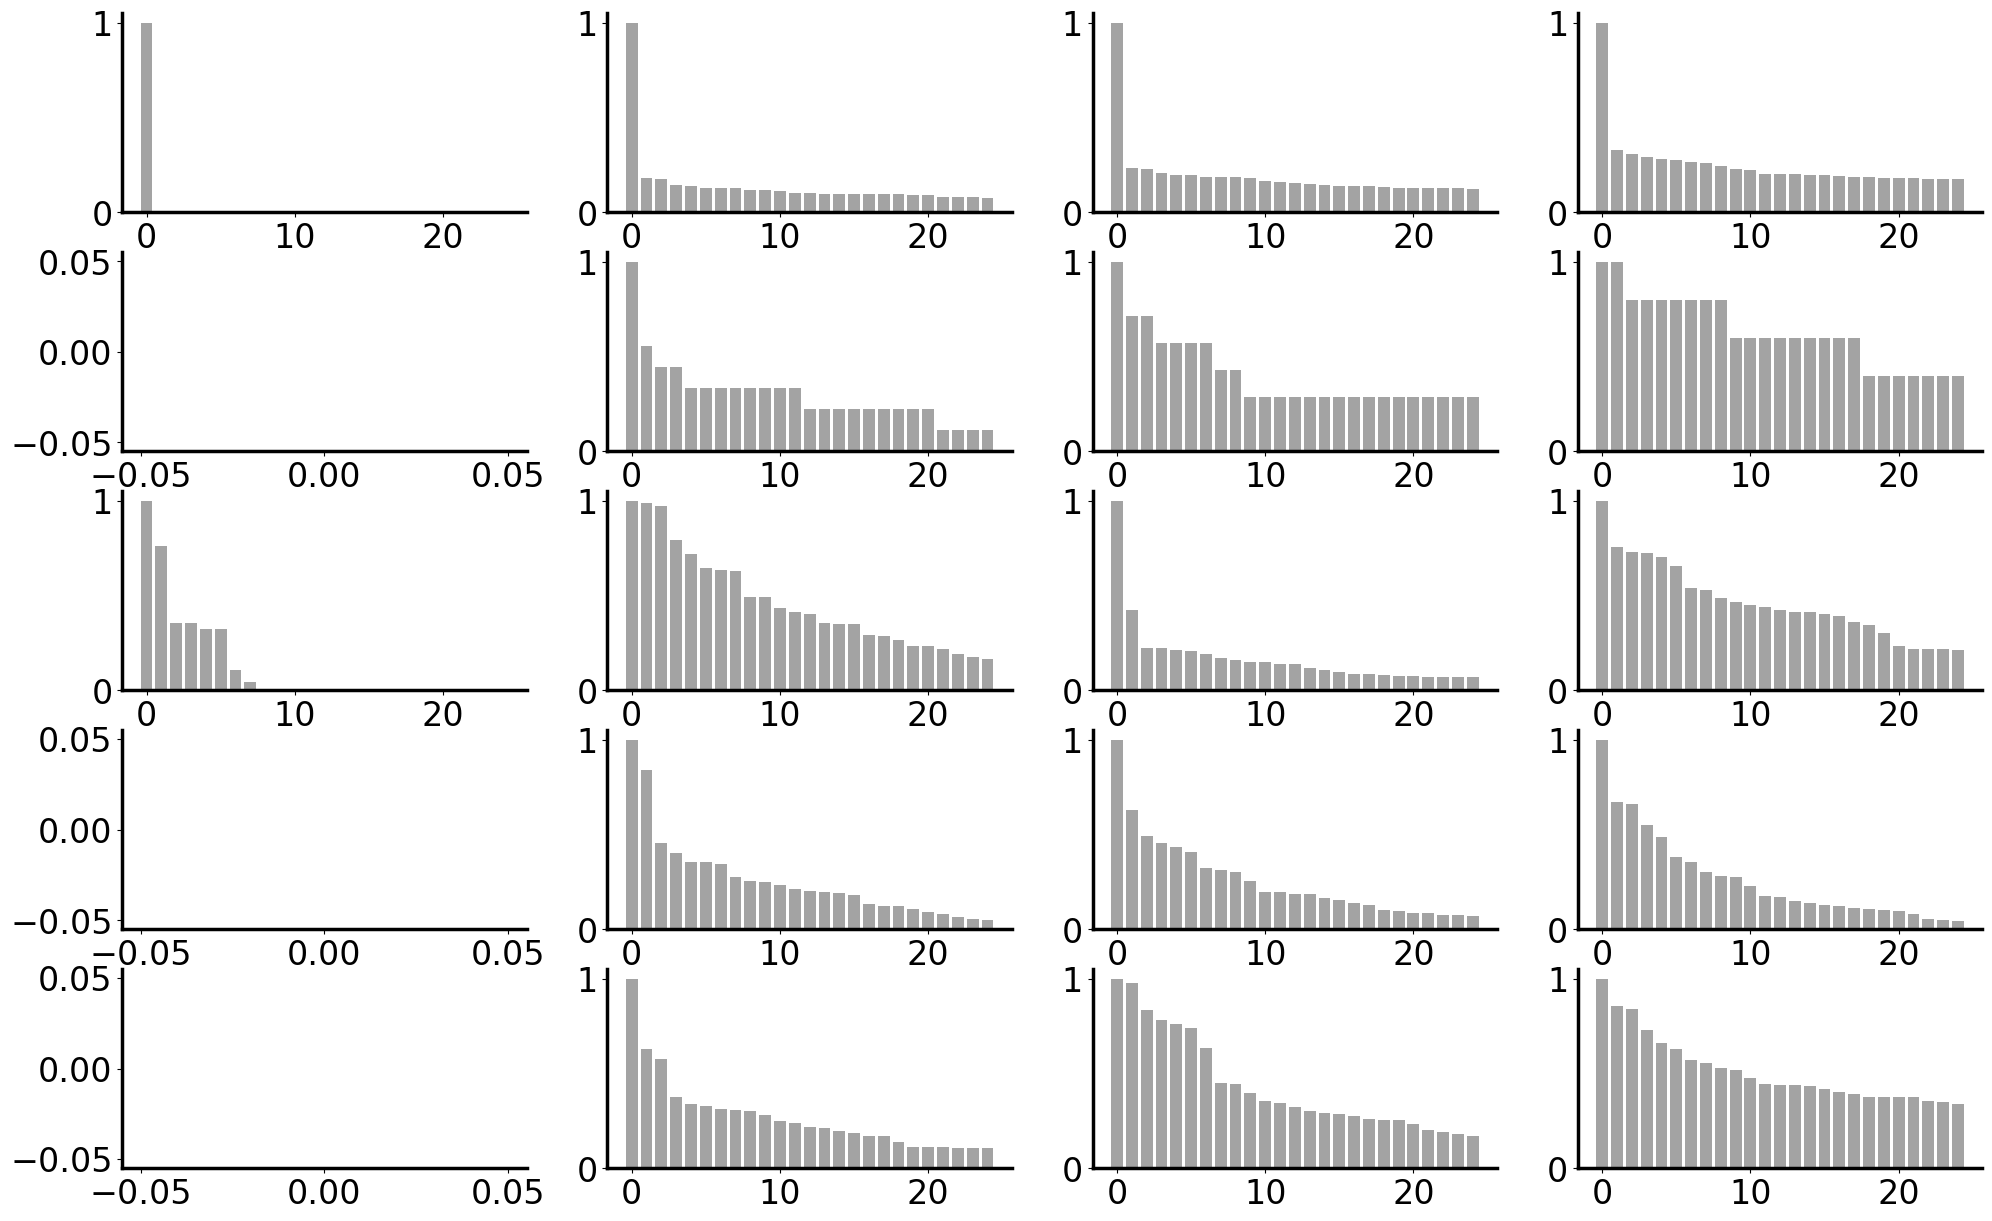

In [18]:
B_fig, B_axes = plt.subplots(len(METRICS)+1, nb_sweep_vals, figsize = (6*nb_sweep_vals, 15))
for (i, sweep_val), (j, metric) in product(enumerate(sweep_vals), enumerate(['X'] + METRICS)):
    ax = B_axes[j,i]
    pdgm = data_dict[metric][sweep_val][0].trimmed(25)
    rng.plot_seq(pdgm, ax = ax)

B_fig.savefig('data/Sfig-metric_analysis_3-B.png')
B_fig.savefig('data/Sfig-metric_analysis_3-B.pdf')

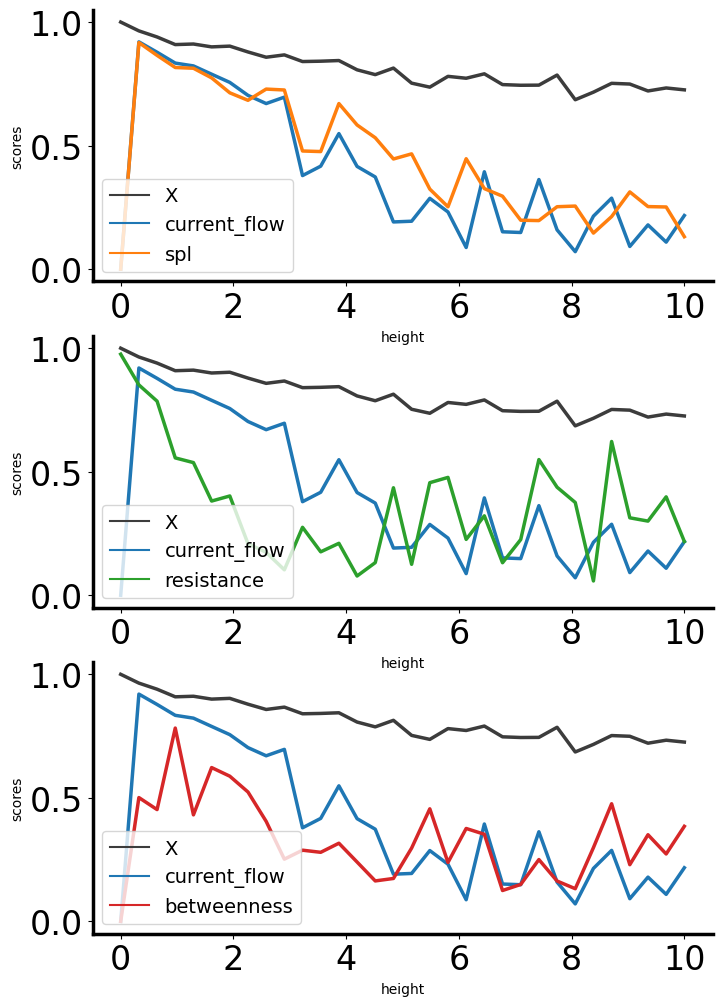

In [19]:
C_fig, C_axes = plt.subplots(len(METRICS) - 1, figsize = (8,12))

for i, metric in enumerate(METRICS[:-1]):
    curr_plot_data = plot_data[plot_data.metric.isin({'X', 'current_flow', metric})].copy()
    curr_plot_data.order = 3
    curr_plot_data.loc[curr_plot_data.metric == 'current_flow', 'order'] = 2
    curr_plot_data.loc[curr_plot_data.metric == 'X', 'order'] = 1
    curr_plot_data = curr_plot_data.sort_values('order')
    ax = C_axes[i]
    ax = sns.lineplot(data = curr_plot_data, 
                      x = sweep_param, 
                      y = 'scores', 
                      hue = 'metric', 
                      linewidth = 2.5,
                      errorbar = ('pi', 50),
                      palette = [COLOR_X, PALETTE[0], PALETTE[i+1]],
                      ax = ax)

    rng.plotting.styling.ax_setup(ax)
    leg = ax.legend(fontsize = 14)

plt.show()
    
C_fig.savefig('data/Sfig-metric_analysis_3-C.png')
C_fig.savefig('data/Sfig-metric_analysis_3-C.pdf')

### Set Parameters

In [4]:
# Network parameters
N = 2**7
er_fc_th = 10

shape_param = 'noise'
nb_shape_vals = 2**5
min_shape_val = 0
max_shape_val = 1

network_generator = rgeom.circle
network_params = {'N' : N, 'er_fc_th' : er_fc_th}
fname_data = Path(f'../../../data/pdgms_circles_N{N}_ERFC{er_fc_th}.json')

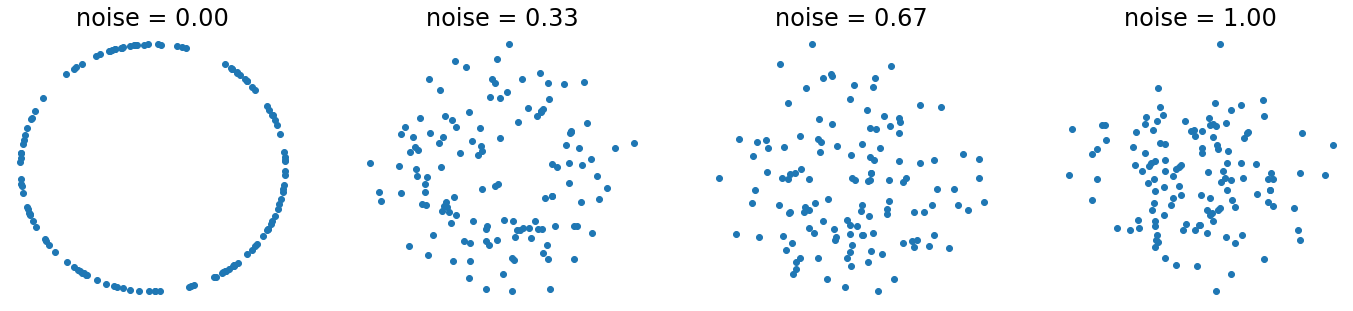

In [5]:
nb_point_clouds = 4

noise_levels = np.linspace(min_shape_val, max_shape_val, nb_point_clouds)

fig, axes = plt.subplots(1, nb_point_clouds, figsize = (6*nb_point_clouds, 5))
for i in range(nb_point_clouds):
    ax = axes[i]
    noise = noise_levels[i]
    
    X = rng.generators.point_clouds.circle(N = N, noise = noise)
    rng.plot_X(X, ax = ax)
    ax.set_title(f'noise = {noise:.2f}', size = 24)

### Calculations

In [31]:
# Calculation parameters
nb_samples = 2**0
new_calculation = True

In [32]:
samples = range(nb_samples)
shapes = np.linspace(min_shape_val, max_shape_val, nb_shape_vals).round(6)

total = nb_samples * nb_shape_vals
pbar = tqdm(product(shapes, samples), total = total)

data_dict = json_to_dictofdictoflist(fname_data, new = new_calculation, lambda_key2 = float)
for shape_val, _ in pbar:
    update_data_dict(data_dict = data_dict,
                     network_generator = network_generator, 
                     network_params = network_params, 
                     shape_val = shape_val,
                     shape_param = shape_param,
                     point_cloud = True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:38<00:00,  1.22s/it]


In [16]:
data_to_json(fname_data, data_dict)

### Visualizations

In [17]:
data_dict = json_to_dictofdictoflist(fname_data, lambda_key2 = float)
scores_df = (data_dict_to_scores_df(data_dict).
                rename({'shape' : shape_param}, axis = 1))

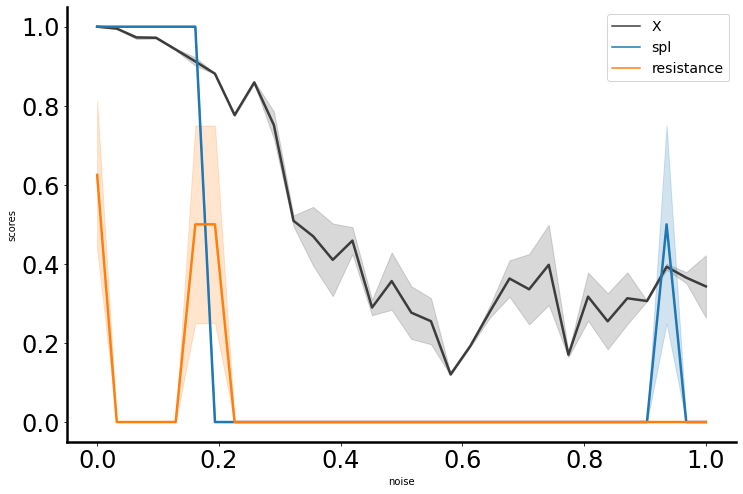

In [18]:
fig, ax = plt.subplots(figsize = (12,8))

plot_data = scores_df[scores_df.metric.isin({'X', 'spl', 'resistance'})]

ax = sns.lineplot(data = plot_data, 
                  x = 'noise', 
                  y = 'scores', 
                  hue = 'metric', 
                  linewidth = 2.5,
                  errorbar = ('pi', 50),
                  palette = [COLOR_X] + PALETTE[0:2],
                  ax = ax)

rng.plotting.styling.ax_setup(ax)

leg = ax.legend(fontsize = 14)

# fig.savefig('plots/direct_metrics_noisy_circle.png')
# fig.savefig('plots/direct_metrics_noisy_circle.pdf')

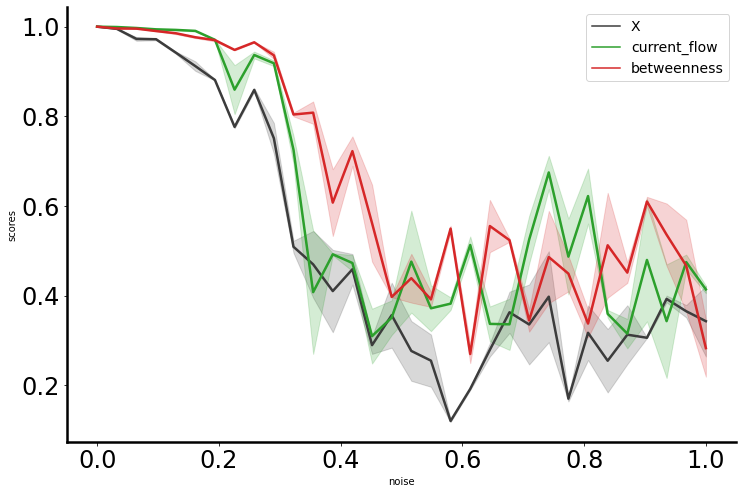

In [19]:
fig, ax = plt.subplots(figsize = (12,8))

plot_data = scores_df[scores_df.metric.isin({'X', 'current_flow', 'betweenness'})]

ax = sns.lineplot(data = plot_data, 
                  x = 'noise', 
                  y = 'scores', 
                  hue = 'metric', 
                  linewidth = 2.5,
                  errorbar = ('pi', 50),
                  palette = [COLOR_X] + PALETTE[2:4],
                  ax = ax)

rng.plotting.styling.ax_setup(ax)

leg = ax.legend(fontsize = 14)

# fig.savefig('plots/centrality_metrics_noisy_circle.png')
# fig.savefig('plots/centrality_metrics_noisy_circle.pdf')

In [23]:
data_dict['X'][0]

[PDiagram([(0.27425438165664673, 1.732373833656311)]),
 PDiagram([(0.32740694284439087, 1.732492446899414)])]

## Von Mises circle - robusnes on sparse regions: $\kappa \approx 1-\beta$

---

## Watts-Strogatz - robustnes on edge-level

In [3]:
# Network parameters
N = 1000
k = 10

### Calculations

In [8]:
# Calculation parameters
nb_betas = 2**1
nb_samples = 2**1

In [11]:
betas = np.logspace(-4, 0, nb_betas).round(6)
samples = range(nb_samples)

fname_data = Path(f'../../../data/pdgms_WS(N{N}, k{k}).json')
data_dict = json_to_dictofdictoflist(fname_data)

In [ ]:
betas = [key for key in data_dict['spl'] if len(data_dict['spl'][key]) < 42]

# Initialize data_dict
t1 = time.time()

nb_loops = sum(1 for _ in product(betas, samples))
for nr, (beta, _) in enumerate(product(betas, samples)):
    if len(data_dict['spl'][beta]) > 42:
        continue
    while True:
        G = nx.watts_strogatz_graph(N, k, beta)
        if nx.is_connected(G):
            break
    
    for metric in METRICS:
        pdgm = rng.pdiagram_from_network(G, metric = metric)
        data_dict[metric][beta].append(pdgm)
            
    t2 = time.time()
    p = (nr+1)/nb_loops
    diff = t2-t1
    print(f'progress: {100*p:.2f}% - {diff:.2f}sec; eta: {diff*(1/p - 1):.2f}sec', end = '\r')

In [ ]:
# Initialize data_dict
data_dict = defaultdict(lambda: defaultdict(list))
t1 = time.time()

nb_loops = sum(1 for _ in product(betas, samples))
for nr, (beta, _) in enumerate(product(betas, samples)):
    while True:
        G = nx.watts_strogatz_graph(N, k, beta)
        if nx.is_connected(G):
            break
    
    for metric in METRICS:
        pdgm = rng.pdiagram_from_network(G, metric = metric)
        data_dict[metric][beta].append(pdgm)
            
    t2 = time.time()
    p = (nr+1)/nb_loops
    diff = t2-t1
    print(f'progress: {100*p:.2f}% - {diff:.2f}sec; eta: {diff*(1/p - 1):.2f}sec', end = '\r')

In [28]:
data_to_json(data_dict)

In [11]:
for metric in list(data_dict.keys()):
    for key in list(data_dict[metric].keys()):
        if len(data_dict[metric][key]) < 30:
            del data_dict[metric][key]

### Visualization

In [24]:
to_concatinate = []
for metric, data in data_dict.items():
    for noise, pdgms in data.items():
        scores = [pdgm.ring_score('gap') for pdgm in pdgms]
        df_metric_chunk = pd.DataFrame({'scores' : scores,
                                        'metric' : metric,
                                        'noise' : noise})
        to_concatinate.append(df_metric_chunk)
        
data_df = pd.concat(to_concatinate, ignore_index = True)

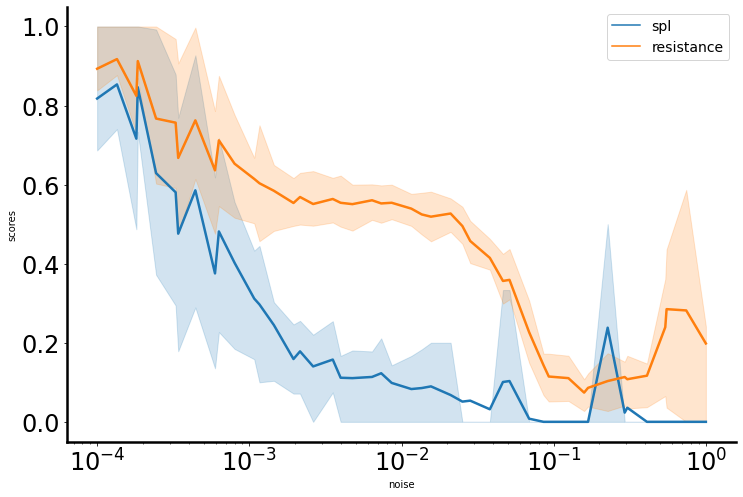

In [25]:
fig, ax = plt.subplots(figsize = (12,8))

plot_data = data_df[data_df.metric.isin({'spl', 'resistance'})]
# plot_data = data_df

ax = sns.lineplot(data = plot_data, 
                  x = 'noise', 
                  y = 'scores', 
                  hue = 'metric', 
                  linewidth = 2.5,
                  errorbar = ('pi', 50),
                  palette = PALETTE[:2],
                  ax = ax)
ax.set(xscale = 'log')
rng.plotting.styling.ax_setup(ax)

leg = ax.legend(fontsize = 14)

# fig.savefig('plots/direct_metrics_noisy_circle.png')
# fig.savefig('plots/direct_metrics_noisy_circle.pdf')

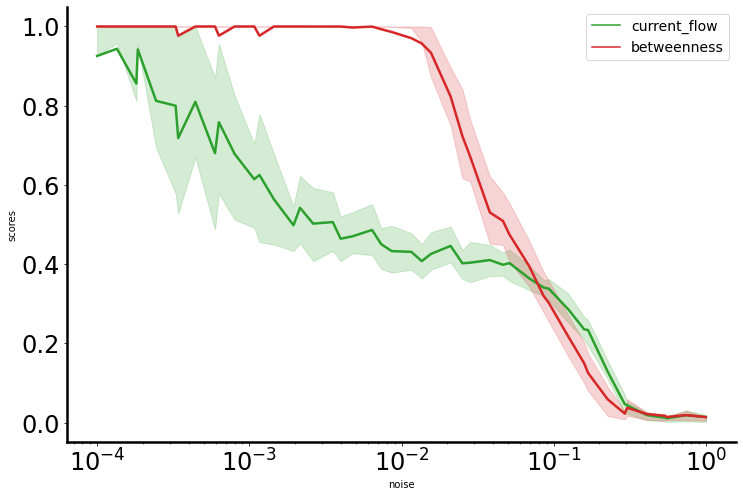

In [26]:
fig, ax = plt.subplots(figsize = (12,8))

plot_data = data_df[data_df.metric.isin({'current_flow', 'betweenness'})]
# plot_data = data_df

ax = sns.lineplot(data = plot_data, 
                  x = 'noise', 
                  y = 'scores', 
                  hue = 'metric', 
                  linewidth = 2.5,
                  errorbar = ('pi', 50),
                  palette = PALETTE[2:4],
                  ax = ax)
ax.set(xscale = 'log')
rng.plotting.styling.ax_setup(ax)

leg = ax.legend(fontsize = 14)

# fig.savefig('plots/centrality_metrics_noisy_circle.png')
# fig.savefig('plots/centrality_metrics_noisy_circle.pdf')

### Annulus

In [3]:
N = 2**8
abs_th = 0.5

nb_radii = 2**4
nb_samples = 2**3

metrics = ['spl', 'current_flow', 'resistance', 'betweenness']
score_df = pd.DataFrame(columns = metrics + ['X'])

radii = np.linspace(0, 1, nb_radii)
samples = range(nb_samples)

# Initialize data_dict
data_dict = defaultdict(lambda: defaultdict(list))
t1 = time.time()

nb_loops = sum(1 for _ in product(radii, samples))
for nr, (r_in, _) in enumerate(product(radii, samples)):
    G, X = rgeom.annulus(N, r_in, abs_th = abs_th, return_point_cloud = True)
    
    pdgm_X = rng.pdiagram_from_point_cloud(X)
    data_dict['X'][r_in].append(pdgm_X)
        
    for metric in metrics:
        pdgm = rng.pdiagram_from_network(G, metric = metric)
        data_dict[metric][r_in].append(pdgm)
        
        if len(pdgm) == 0:
            print('wow')
            
    t2 = time.time()
    p = (nr+1)/nb_loops
    diff = t2-t1
    print(f'progress: {100*p:.2f}% - {diff:.2f}sec; eta: {diff*(1/p - 1):.2f}sec', end = '\r')

In [8]:
to_concatinate = []
for metric, data in data_dict.items():
    for r_inner, pdgms in data.items():
        scores = [1-get_second(pdgm) for pdgm in pdgms]
        df_metric_chunk = pd.DataFrame({'scores' : scores,
                                        'metric' : metric,
                                        'inner_radius' : r_inner})
        to_concatinate.append(df_metric_chunk)
        
data_df = pd.concat(to_concatinate, ignore_index = True)

/Users/markusyoussef/Documents/coding/venvs/ringity/lib/python3.9/site-packages/ringity/classes/pdiagram.py:230: RuntimeWarning: invalid value encountered in divide
  return pseq/self.signal


In [11]:
to_concatinate = []
for metric, data in data_dict.items():
    for r_inner, pdgms in data.items():
        scores = [pdgm.ring_score() for pdgm in pdgms]
        df_metric_chunk = pd.DataFrame({'scores' : scores,
                                        'metric' : metric,
                                        'inner_radius' : r_inner})
        to_concatinate.append(df_metric_chunk)
        
data_df = pd.concat(to_concatinate, ignore_index = True)

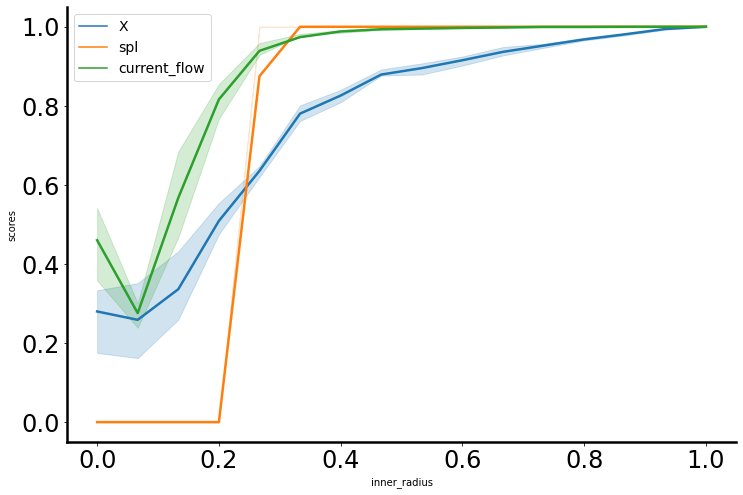

In [13]:
fig, ax = plt.subplots(figsize = (12,8))

plot_data = data_df[data_df.metric.isin({'X', 'spl', 'current_flow'})]
# plot_data = data_df
ax = sns.lineplot(data = plot_data, 
                  x = 'inner_radius', 
                  y = 'scores', 
                  hue = 'metric', 
                  linewidth = 2.5,
                  errorbar = ('pi', 50),
                  ax = ax)

rng.plotting.styling.ax_setup(ax)

leg = ax.legend(fontsize = 14)

In [5]:
row_data = []
for metric, data in data_dict.items():
    for r_i, pdgms in data.items():
        row_data.append({'metric' : metric})
        scores = [pdgm.ring_score() for pdgm in pdgms]

        row_data[-1]['inner_radius'] = r_i

        row_data[-1]['avg_scores'] = np.mean(scores)
        row_data[-1]['lqt_scores'] = np.percentile(scores, 25)
        row_data[-1]['uqt_scores'] = np.percentile(scores, 75)
        
data_df = pd.DataFrame(row_data)

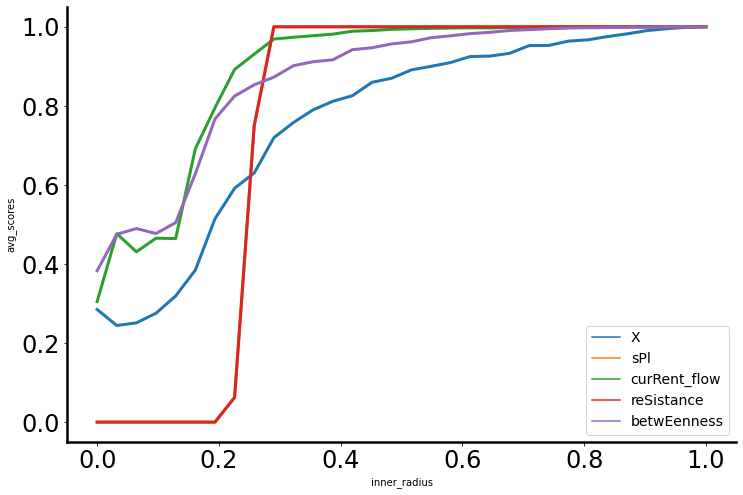

In [7]:
fig, ax = plt.subplots(figsize = (12,8))

ax = sns.lineplot(data = data_df, 
                  x = 'inner_radius', 
                  y = 'avg_scores', 
                  hue = 'metric', 
                  linewidth = 3,
                  ax = ax)

rng.plotting.styling.ax_setup(ax)

leg = ax.legend(fontsize = 14)

### Cylinder

In [47]:
N = 2**8
abs_th = 1
h_max = 10

nb_heights = 2**4
nb_samples = 2**3

metrics = ['spl', 'current_flow', 'resistance', 'betweenness']
score_df = pd.DataFrame(columns = metrics + ['X'])

heights = np.linspace(0, h_max, nb_heights)
samples = range(nb_samples)

# Initialize data_dict
data_dict = defaultdict(lambda: defaultdict(list))
t1 = time.time()

nb_loops = sum(1 for _ in product(heights, samples))
for nr, (height, _) in enumerate(product(heights, samples)):
    while True:
        G, X = rgeom.cylinder(int(N * (1+height/h_max)), 
                              height = height, 
                              abs_th = abs_th, 
                              return_point_cloud = True)
        if nx.is_connected(G):
            break
    
    pdgm_X = rng.pdiagram_from_point_cloud(X)
    data_dict['X'][height].append(pdgm_X)
        
    for metric in metrics:
        pdgm = rng.pdiagram_from_network(G, metric = metric)
        data_dict[metric][height].append(pdgm)
        
        if len(pdgm) == 0:
            print('wow')
            
    t2 = time.time()
    p = (nr+1)/nb_loops
    diff = t2-t1
    print(f'progress: {100*p:.2f}% - {diff:.2f}sec; eta: {diff*(1/p - 1):.2f}sec', end = '\r')

In [49]:
def get_second(pdgm):
    try:
        return pdgm.psequence('signal')[1]
    except IndexError:
        return 0

In [50]:
to_concatinate = []
for metric, data in data_dict.items():
    for height, pdgms in data.items():
        scores = [1-get_second(pdgm) for pdgm in pdgms]
        df_metric_chunk = pd.DataFrame({'scores' : scores,
                                        'metric' : metric,
                                        'height' : height})
        to_concatinate.append(df_metric_chunk)
        
data_df = pd.concat(to_concatinate, ignore_index = True)

/Users/markusyoussef/Documents/coding/venvs/ringity/lib/python3.9/site-packages/ringity/classes/pdiagram.py:213: RuntimeWarning: invalid value encountered in divide
  return pseq/self.signal


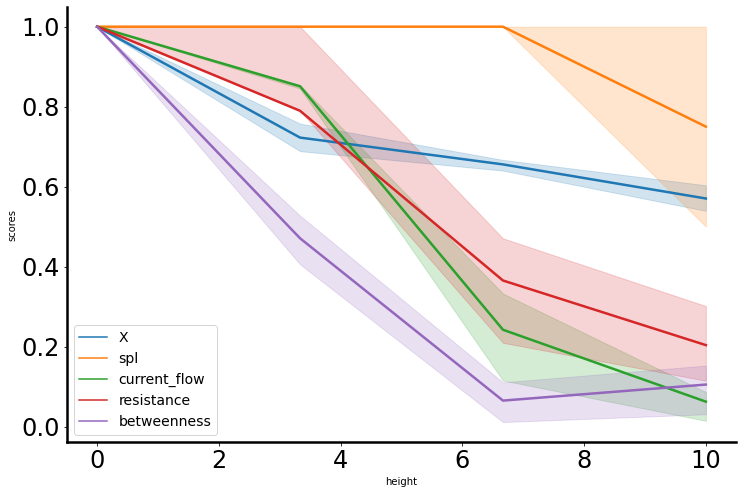

In [52]:
fig, ax = plt.subplots(figsize = (12,8))

plot_data = data_df[data_df.metric.isin({'X', 'spl', 'current_flow'})]
plot_data = data_df
ax = sns.lineplot(data = plot_data, 
                  x = 'height', 
                  y = 'scores', 
                  hue = 'metric', 
                  linewidth = 2.5,
                  errorbar = ('pi', 50),
                  ax = ax)

rng.plotting.styling.ax_setup(ax)

leg = ax.legend(fontsize = 14)